VAEs dynamiques : https://arxiv.org/abs/2008.12595

# Training a Variational RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import timeit

In [2]:
from libs.vrnn_lib_sprites import seed_everything, VRNN
from libs.vrnn_lib_sprites import loss_function, train
from libs.vrnn_lib_sprites import BetaLinearScheduler, BetaThresholdScheduler
from libs.vrnn_lib_sprites import plot_losses, sample_predictions

In [3]:
# Set seed for reproducibility
seed_everything(42)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3090
Total GPU Memory: 23.7 GB


# Modèle

### Variational RNN :

The full factorization of $p(z_{1:T}, x_{1:T})$ is used:

\begin{align}
p(z_{1:T}, x_{1:T}) &= \prod_{t=1}^T p(z_t, x_t \vert z_{1:t-1}, x_{1:t-1}) \\
&= \prod_{t=1}^T p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t}) p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1}) \\
\end{align}

Where the two distributions $p_{\theta_z}$ and $p_{\theta_x}$ are Gaussians :

\begin{align}

p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t}) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}), \text{diag}(\sigma_{\theta_x}^{2}(\overrightarrow{g}_{t-1}, h_{t}))) \\
d_x(\overrightarrow{g}_{t-1}, h_{t}) &= [ \mu_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}), \sigma_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}) ] \\

p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(\overrightarrow{g}_{t-1}, h_{t-1}))) \\
d_z(\overrightarrow{g}_{t-1}, h_{t-1}) &= [ \mu_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}), \sigma_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}) ] \\

\end{align}

où $d_x, d_z$ sont des MLP,

et où $h_t = \text{LSTM}(z_t, h_{t-1})$ est un forward LSTM qui encode $z_{1:t}$

et $\overrightarrow{g}_t = \text{LSTM}(x_t, \overrightarrow{g}_{t-1})$ est un forward LSTM qui encode $x_{1:t}$

### Modèle inférence

Le "true posterior" s'écrit :
\begin{align}
p_{\theta}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T p_{\theta} (z_t \vert z_{1:t-1}, x_{1:T} ) \\
\end{align}

où la première écriture est la stricte application de la chain rule.

On choisit comme approximation du posterior (=encodeur) une formulation calquée sur le vrai posterior :

\begin{align}
q_{\phi}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T q_{\phi} (z_{t} \vert z_{1:t-1}, x_{1:T}) \\
\end{align}

Et:
\begin{align}
q_{\phi} (z_{t} \vert z_{1:t-1}, x_{1:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}), \text{diag} (\sigma_{\phi}^2(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}))) \\
d_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}) &= [ \mu_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}), \sigma_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}) ]
\end{align}

où $d_{\phi}$ est un MLP, et

$\overleftarrow{g}_t = \text{LSTM}(x_t, \overleftarrow{g}_{t-1})$ est un backward LSTM qui encode $x_{t:T}$

# Implémentation de l'inférence

Il y a ici quelques choix d'implémentations différents de ceux du papier originel, et adapté au dataset **Sprites** :

- **trois** LSTMs distincts pour encoder $z_{1:t}$, $x_{1:t}$ et $x_{t:T}$

- CNN2D pour PreEncoder et PostDecoder

# Training

Le modèle s'entraîne en maximisant un ELBO, dont la formulation dans le cas du VRNN est:

\begin{align}
    \begin{split}
    \mathcal{L}(\theta, \phi; X) &= \sum_{t=1}^T  \mathbb{E}{q_{\phi}(z_{1:t} \vert x_{1:T})} \log{p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t})} \\ &- \sum_{t=1}^T \mathbb{E}{q_{\phi}(z_{1:t-1} \vert x_{1:T})} \mathbb{KL}{q_{\phi}(z_t \vert z_{1:t-1}, x_{1:T})}{p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1})} 
    \end{split}    
\end{align}
<!-- 
Les deux termes s'explicitent de la façon suivante (avec $D$ dimension de l'espace des observations) :

\begin{align}
p_{\theta_x}(x_t \vert z_t) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(z_t), \text{diag}(\sigma_{\theta_x}^2(z_t))) \\
\log{p_{\theta_x}(x_t \vert z_t)} &= -\frac{D}{2} \log{2\pi} - \frac{1}{2}\log{\vert \text{diag}(\sigma_{\theta_x}^2(z_t)) \vert} - 
\frac{1}{2} \left[ (x_t - \mu_{\theta_x}(z_t))^T (\text{diag}(\sigma_{\theta_x}^2(z_t)))^{-1} (x_t - \mu_{\theta_x}(z_t)) \right] \\
&= - \frac{1}{2} \left( \sum_{i=1}^D \log{\sigma_{\theta_x}^2(z_t)}\vert_{i} + (x_t - \mu_{\theta_x}(z_t))^T \text{diag} \frac{1}{\sigma_{\theta_x}^2(z_t)} (x_t - \mu_{\theta_x}(z_t)) + D \log{2\pi} \right)
\end{align}

Et la KL entre les deux Gaussiennes:

\begin{align}
q_\phi(z_t \vert z_{t-1}, x_{t:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(g_t), \text{diag}(\sigma_\phi^2(g_t))) \\
p_{\theta_z}(z_t \vert z_{t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(z_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(z_{t-1}))) \\
\end{align}

a une close form (avec $Z$ dimension de l'espace latent):

\begin{align}
\text{D}_{\text{KL}}(q_\phi \vert\vert p_{\theta_z}) &= \frac{1}{2} \left[ \text{Tr}(\text{diag}(\sigma_{\theta_z}^{2})^{-1} \text{diag}(\sigma_\phi^2) ) + (\mu_{\theta_z} - \mu_\phi)^T (\text{diag}(\sigma_{\theta_z}^{2})^{-1}) (\mu_{\theta_z} - \mu_\phi) +
\log{\frac{\vert \text{diag}(\sigma_{\theta_z}^{2})\vert}{\vert \text{diag}(\sigma_\phi^2) \vert} } \right] \\
&= \frac{1}{2}\left[ \sum_{i=1}^Z \log{\sigma_{\theta_z}^{2}}\vert_i - \sum_{i=1}^Z \log{\sigma_{\phi}^{2}}\vert_i +
 (\mu_{\theta_z} - \mu_\phi)^T \text{diag}(\frac{1}{\sigma_{\theta_z}^{2}}) (\mu_{\theta_z} - \mu_\phi) + \sum_{i=1}^Z \frac{\sigma_{\phi}^{2}\vert_i} {\sigma_{\theta_z}^{2}\vert_i} - Z 
\right]
\end{align} -->

# Data

Dataset **Sprites** : https://arxiv.org/abs/1803.02991

Characters with 6 attributes (skin color, tops, pants and hairstyle), each taking 4 possibles values : $6**4 = 1296$ possibilities.

Performing 3 possibles actions (walking, casting spells and slashing) each with 3 possible view angles : 9 actions.

Total is 1296 x 9 = 11664 : 1000 for training, 296 for test.

In [5]:
from libs.load_sprites import sprites_act
import imageio.v2 as imageio

In [6]:
X_train, X_test, A_train, A_test, D_train, D_test = sprites_act('data/sprites/', return_labels=True)

walk front 0 0 0
walk left 0 1 1
walk right 0 2 2
spellcard front 1 0 3
spellcard left 1 1 4
spellcard right 1 2 5
slash front 2 0 6
slash left 2 1 7
slash right 2 2 8
A_test.shape: (2664, 8, 4, 6), D_test.shape: (2664, 8, 9), X_test.shape: (2664, 8, 64, 64, 3)
X_train.shape: (9000, 8, 64, 64, 3), X_test.min(): 0.0, X_test.max(): 0.99609375
data loaded in 2.16 seconds...


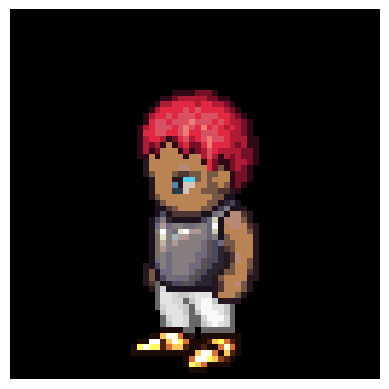

In [7]:
e = X_train[0,0,:]

plt.imshow(e)
plt.axis('off')
plt.show()

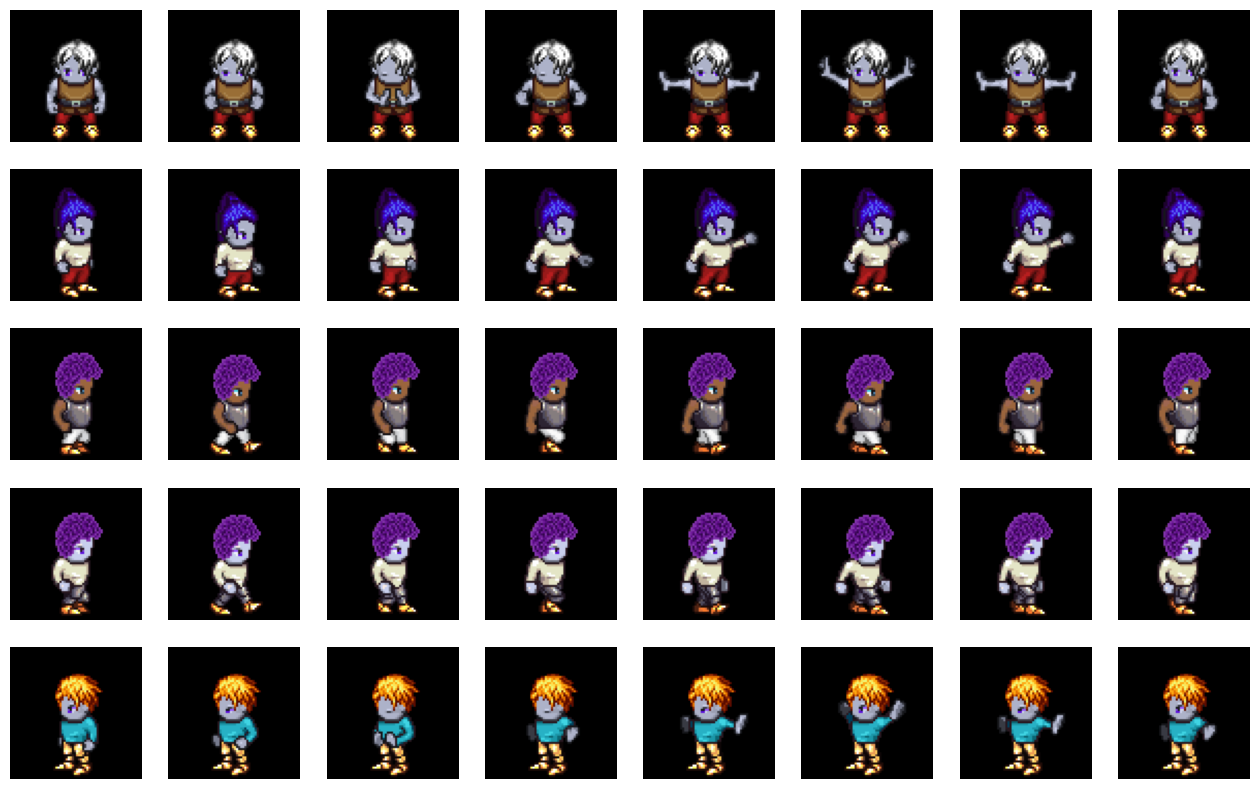

In [8]:
N = X_train.shape[0]
T = X_train.shape[1]
N_SAMPLES = 5

idx = np.random.choice(N, N_SAMPLES, replace=False)

fig, ax = plt.subplots(nrows=N_SAMPLES, ncols=T, figsize=(T*2, N_SAMPLES*2))

for i, id_seq in enumerate(idx):
    images = X_train[id_seq]
    for t in range(T):
        ax[i, t].imshow(images[t])
        ax[i, t].axis('off')

Testing PreEncoder and PostDecoder

In [9]:
X_DIM = 8   # NB : X_DIM = 8 gives good results for the AE with the two CNNs only

In [10]:
# test PreEncoderCNN : (T,B,64,64,3) -> (T,B,Dx)

from libs.vrnn_lib_sprites import PreEncoderCNN
pre_encoder = PreEncoderCNN(Dx=X_DIM).to(device)

test_in = torch.randn(10, 5, 64, 64, 3).to(device)  # (T, B, W, H, C)
output = pre_encoder(test_in)

print(f"Shape in = {test_in.shape}")
print(f"Shape out = {output.shape}")

Shape in = torch.Size([10, 5, 64, 64, 3])
Shape out = torch.Size([10, 5, 8])


In [11]:
# test PostDecoderCNN : (T,B,Dx) -> (T,B,64,64,3)

from libs.vrnn_lib_sprites import PostDecoderCNN
post_decoder = PostDecoderCNN(Dx=X_DIM).to(device)

test_in = torch.randn(10, 5, X_DIM).to(device)  # (T, B, Dx)
output = post_decoder(test_in)

print(f"Shape in = {test_in.shape}")
print(f"Shape out = {output.shape}")  # Should be (T, B, 64, 64, 3)

Shape in = torch.Size([10, 5, 8])
Shape out = torch.Size([10, 5, 64, 64, 3])


# Dataset / Dataloader

In [12]:
# form datasets and dataloaders for PyTorch training
class CSRDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]
    
train_dataset = CSRDataset(X_train)
test_dataset = CSRDataset(X_test)

In [13]:
batch_size = 512

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# VRNN Parameters

In [14]:
X_DIM = 8 # Dimension of the observation space (exiting the CNN Encoder, inputing the VRNN and the CNN Decoder)
Z_DIM = 32 # Dimension of the latent space
RNN_X_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for observations
RNN_Z_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for latent variables

In [15]:
vrnn = VRNN(
    input_dim = X_DIM,
    latent_dim = Z_DIM,
    rnn_x_hidden_dim = RNN_X_H_DIM,
    rnn_z_hidden_dim = RNN_Z_H_DIM,
    device=device
).to(device)

print(vrnn)

VRNN(observation_dim=8, latent_dim=32)
Bidirectional LSTM (input_size=8, rnn_x_hidden_size=128, num_layers=1)
Forward LSTM (input_size=32, rnn_z_hidden_size=128, num_layers=1)
Encoder MLP (z_dim=32, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=384, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=64, bias=True)
)
Latent State Transition MLP (z_dim=32, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=256, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=64, bias=True)
)
Decoder MLP (x_dim=8, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=256, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_

# Testing the pipeline

In [16]:
N = 10
# get data from dataloader
x = torch.tensor(X_train[:N, :, : ,: , :]).to(device)  # (B, T, W, H, C)
print(f"Shape of input out of X_train (batch {N} samples) = {x.shape}")

# get the right shape
x2 = x.permute(1,0,2,3,4)  # (T, B, W, H, C)
print(f"Shape of input after permute = {x2.shape}")

# preencode
x3 = pre_encoder(x2)  # (T, B, Dx)
print(f"Shape of input after preencoding = {x3.shape}")

# go through the VRNN
x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t = vrnn(x3)  # mu_x_t (T,B,Dx), logvar_x_t (T,B,Dx)
print(f"Shape of input after VRNN : mu_x_t = {mu_x_t.shape}, logvar_x_t = {logvar_x_t.shape}")

# sample some x with Dx
sampled_xs = mu_x_t + torch.randn_like(mu_x_t) * torch.exp(0.5 * logvar_x_t)  # (T, B, Dx)
print(f"Shape of sampled x = {sampled_xs.shape}")

# decode the sampled x into images
x_hat = post_decoder(sampled_xs)  # (T, B, 64, 64, 3)
print(f"Shape of decoded x_hat = {x_hat.shape}")

# get the original shape back
x_hat = x_hat.permute(1, 0, 2, 3, 4)  # (B, T, W, H, C)
print(f"Shape of x_hat after permute = {x_hat.shape}")

# loss
loss = (x - x_hat).pow(2).sum(dim=(2, 3, 4))  # (T, B)
loss = loss.mean(dim=(0, 1))  # (,)
print(f"Shape of loss = {loss.shape}, Loss value = {loss.item()}")

Shape of input out of X_train (batch 10 samples) = torch.Size([10, 8, 64, 64, 3])
Shape of input after permute = torch.Size([8, 10, 64, 64, 3])
Shape of input after preencoding = torch.Size([8, 10, 8])
Shape of input after VRNN : mu_x_t = torch.Size([8, 10, 8]), logvar_x_t = torch.Size([8, 10, 8])
Shape of sampled x = torch.Size([8, 10, 8])
Shape of decoded x_hat = torch.Size([8, 10, 64, 64, 3])
Shape of x_hat after permute = torch.Size([10, 8, 64, 64, 3])
Shape of loss = torch.Size([]), Loss value = 2522.34375


# Training loop

In [17]:
# One Training Step
def train_step(pre_encoder, vrnn, postdecoder, train_loader, learning_rate, criterion, optimizer, beta=None):
    """Perform one training step on the chain of models:
    - get batch data
    - go through preencoder
    - go through vrnn
    - go through postdecoder
    - compute loss
    - backpropagate and update weights
    """
    
    # training mode
    pre_encoder.train()
    vrnn.train()
    post_decoder.train()
    
    # training loop
    rec_vrnn_epoch_loss = 0.0
    kl_epoch_loss = 0.0
    rec_cnn_epoch_loss = 0.0
    total_epoch_loss = 0.0
    
    for x_batch in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        x_batch = x_batch.to(device)  # Move batch to device
        # run the pipeline
        x_encoded = pre_encoder(x_batch.permute(1, 0, 2, 3, 4).to(device))  # (T, B, Dx)
        x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t = vrnn(x_encoded)  # mu_x_t (T,B,Dx), logvar_x_t (T,B,Dx)
        sampled_xs = mu_x_t + torch.randn_like(mu_x_t) * torch.exp(0.5 * logvar_x_t)  # (T, B, Dx)
        x_hat = post_decoder(sampled_xs)  # (T, B, 64, 64, 3)
        # x_hat = post_decoder(x_encoded)  # (T, B, 64, 64, 3)  ND - AE SEULEMENT !!
        x_hat = x_hat.permute(1, 0, 2, 3, 4)  # (B, T, W, H, C)
        # compute the loss
        rec_loss_vrnn_batch, kl_batch, total_vrnn_loss_batch = loss_function(x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t, beta=beta)
        # kl = torch.tensor(0.0)  # Placeholder for KL divergence, in case we train AE only
        # compute L2 loss on images
        rec_cnn_batch = (x_batch - x_hat).pow(2).sum(dim=(2, 3, 4))   # (T, B)
        rec_cnn_batch = rec_cnn_batch.mean(dim=(0, 1)) # (,)
        # compute the total loss
        total_loss_batch = total_vrnn_loss_batch + rec_cnn_batch
        # backpropagation
        total_loss_batch.backward()  # Backward pass
        optimizer.step()  # Update weights
        # sum over batch
        rec_vrnn_epoch_loss += rec_loss_vrnn_batch.item()
        kl_epoch_loss += kl_batch.item()
        rec_cnn_epoch_loss += rec_cnn_batch.item()
        total_epoch_loss += total_loss_batch.item()
        print(f"(Training) - Batch Loss: {total_loss_batch.item():.4f}, Rec Loss VRNN: {rec_loss_vrnn_batch.item():.4f}, KL Loss: {kl_batch.item():.4f}, Rec Loss CNNs: {rec_cnn_batch.item():.4f}", end='\r')
    
    # Average the losses over the entire epoch
    rec_vrnn_epoch_loss /= len(train_loader)
    kl_epoch_loss /= len(train_loader)
    rec_cnn_epoch_loss /= len(train_loader)
    total_epoch_loss /= len(train_loader)
        
    return pre_encoder, vrnn, post_decoder, rec_vrnn_epoch_loss, kl_epoch_loss, rec_cnn_epoch_loss, total_epoch_loss

In [18]:
# One Test Step
def test_step(pre_encoder, vrnn, postdecoder, test_loader):
    """Perform one test step on the chain of models."""
    
    # mode evaluation
    pre_encoder.eval()
    vrnn.eval()
    post_decoder.eval()
    
    # testing loop
    rec_vrnn_epoch_loss = 0.0
    kl_epoch_loss = 0.0
    rec_cnn_epoch_loss = 0.0
    total_epoch_loss = 0.0
    
    with torch.no_grad():
        for x_batch in test_loader:
            
            x_batch = x_batch.to(device)  # Move batch to device
            # run the pipeline
            x_encoded = pre_encoder(x_batch.permute(1, 0, 2, 3, 4).to(device))  # (T, B, Dx)
            x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t = vrnn(x_encoded)  # mu_x_t (T,B,Dx), logvar_x_t (T,B,Dx)
            sampled_xs = mu_x_t + torch.randn_like(mu_x_t) * torch.exp(0.5 * logvar_x_t)  # (T, B, Dx)
            x_hat = post_decoder(sampled_xs)  # (T, B, 64, 64, 3)
            # x_hat = post_decoder(x_encoded)  # (T, B, 64, 64, 3)  ND - AE SEULEMENT !!
            x_hat = x_hat.permute(1, 0, 2, 3, 4)  # (B, T, W, H, C)
            # compute the loss
            rec_loss_vrnn_batch, kl_batch, total_vrnn_loss_batch = loss_function(x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t)
            # kl = torch.tensor(0.0)  # Placeholder for KL divergence, as we are not using it in AE only
            rec_cnn_batch = (x_batch - x_hat).pow(2).sum(dim=(2, 3, 4))   # (T, B)
            rec_cnn_batch = rec_cnn_batch.mean(dim=(0, 1)) # (,)
            total_loss_batch = total_vrnn_loss_batch + rec_cnn_batch
            # sum over batch
            rec_vrnn_epoch_loss += rec_loss_vrnn_batch.item()
            kl_epoch_loss += kl_batch.item()
            rec_cnn_epoch_loss += rec_cnn_batch.item()
            total_epoch_loss += total_loss_batch.item()
            print(f"(Validation) - Batch Loss: {total_loss_batch.item():.4f}, Rec Loss VRNN: {rec_loss_vrnn_batch.item():.4f}, KL Loss: {kl_batch.item():.4f}, Rec Loss CNNs: {rec_cnn_batch.item():.4f}", end='\r')
            
    # Average the losses over the entire epoch
    rec_vrnn_epoch_loss /= len(train_loader)
    kl_epoch_loss /= len(train_loader)
    rec_cnn_epoch_loss /= len(train_loader)
    total_epoch_loss /= len(train_loader)
    
    return rec_vrnn_epoch_loss, kl_epoch_loss, rec_cnn_epoch_loss, total_epoch_loss

In [19]:
pre_encoder = PreEncoderCNN(Dx=X_DIM).to(device)
post_decoder = PostDecoderCNN(Dx=X_DIM).to(device)
vrnn = VRNN(
    input_dim = X_DIM,
    latent_dim = Z_DIM,
    rnn_x_hidden_dim = RNN_X_H_DIM,
    rnn_z_hidden_dim = RNN_Z_H_DIM,
    device=device
).to(device)

# optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(list(pre_encoder.parameters()) + list(vrnn.parameters()) + list(post_decoder.parameters()), lr=learning_rate)

# loss
criterion = loss_function

In [20]:
# Early stopping class to prevent overfitting

class EarlyStoppingCallback:
    def __init__(self, patience=1, min_delta=0):
        # how many epochs do we accept with validation loss non decreasing
        self.patience = patience
        # tolerance for non decrease
        self.min_delta = min_delta
        # how many epochs without validation loss decrease
        self.counter = 0
        # minimum validation loss to beat
        self.min_validation_loss = float('inf')
        self.status = False

    def early_stop(self, validation_loss):
        # is the last validation loss better than the current minimum ?
        # status = True means stop training
        if validation_loss < self.min_validation_loss:
            # yes : update minimum value and reset counter
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.status = False
            # no : are we within tolerance ?
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            # no : increase counter (losing patience)
            self.counter += 1
            # have we lost patience ?
            if self.counter >= self.patience:
                # yes
                self.status = True
            else:
                # no
                self.status = False

        return self.status, self.counter

patience = 20
early_stopper = EarlyStoppingCallback(patience, min_delta=1e-3)

Using GPU: NVIDIA GeForce RTX 3090 with 23.7 GB memory
Beta scheduler: BetaLinearScheduler(beta_start=0.000e+00, beta_end=1.000e+00, epoch_start=100, epoch_end=200, num_epochs=100)
Epoch [1      .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.0460e+03 (Rec VRNN) 7.8844e+00 (KL) 1.9209e+00 (Rec CNN) 2.0381e+03 -- TEST : (Total) 2.7833e+02 (Rec VRNN) 3.0914e+00 (KL) 1.1061e+00 (Rec CNN) 2.7413e+02 -- Early stopping counter: 0 / 20


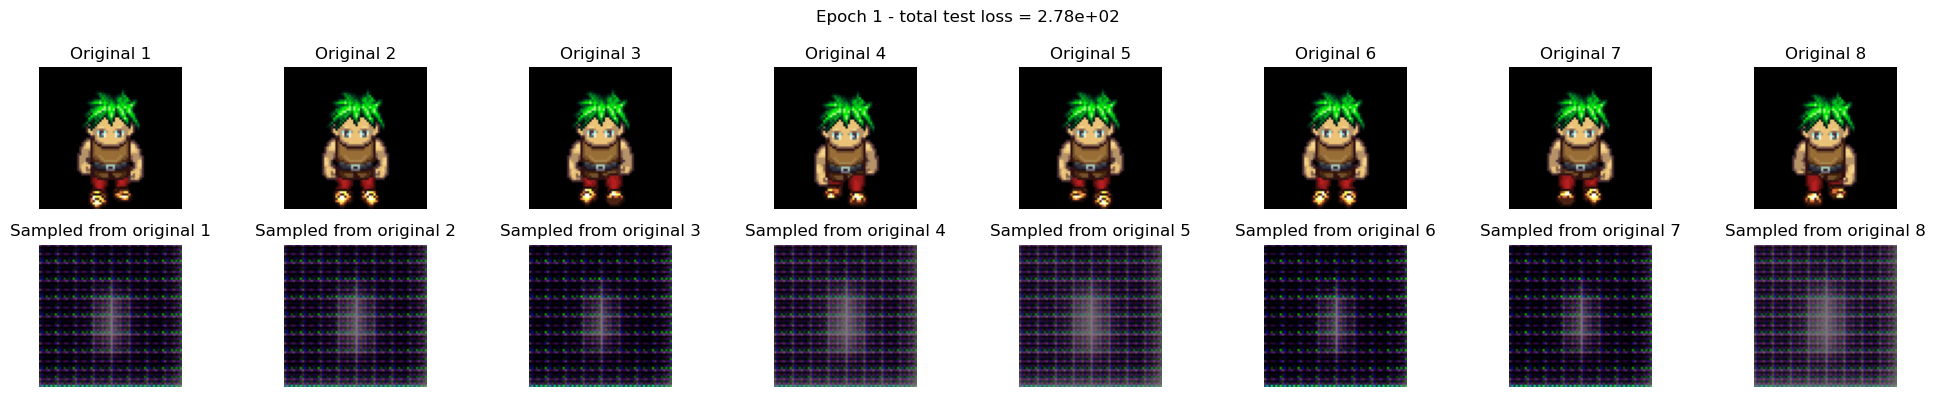

Epoch [2      .../... 300   ] beta = 0.00 -- TRAIN : (Total) 5.1190e+02 (Rec VRNN) 8.0859e+00 (KL) 6.1204e+00 (Rec CNN) 5.0382e+02 -- TEST : (Total) 1.3481e+02 (Rec VRNN) 2.5995e+00 (KL) 2.5708e+00 (Rec CNN) 1.2964e+02 -- Early stopping counter: 0 / 20
Epoch [3      .../... 300   ] beta = 0.00 -- TRAIN : (Total) 3.8197e+02 (Rec VRNN) 7.6149e+00 (KL) 7.8459e+00 (Rec CNN) 3.7435e+02 -- TEST : (Total) 1.2604e+02 (Rec VRNN) 2.4706e+00 (KL) 2.6331e+00 (Rec CNN) 1.2093e+02 -- Early stopping counter: 0 / 20
Epoch [4      .../... 300   ] beta = 0.00 -- TRAIN : (Total) 3.6464e+02 (Rec VRNN) 7.2256e+00 (KL) 7.9204e+00 (Rec CNN) 3.5741e+02 -- TEST : (Total) 1.2126e+02 (Rec VRNN) 2.3331e+00 (KL) 2.6626e+00 (Rec CNN) 1.1627e+02 -- Early stopping counter: 0 / 20
Epoch [5      .../... 300   ] beta = 0.00 -- TRAIN : (Total) 3.5061e+02 (Rec VRNN) 6.7592e+00 (KL) 8.2261e+00 (Rec CNN) 3.4385e+02 -- TEST : (Total) 1.1740e+02 (Rec VRNN) 2.1602e+00 (KL) 2.8765e+00 (Rec CNN) 1.1236e+02 -- Early stopping coun

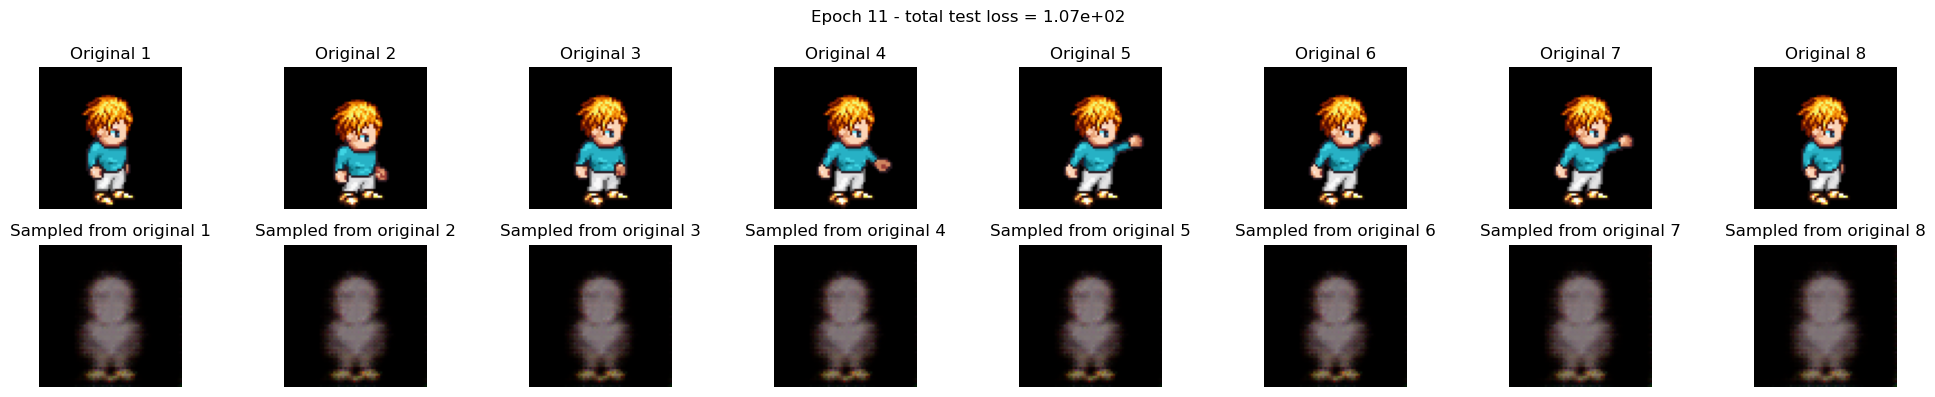

Epoch [12     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.9806e+02 (Rec VRNN) 1.7869e+00 (KL) 2.2323e+01 (Rec CNN) 2.9627e+02 -- TEST : (Total) 1.0599e+02 (Rec VRNN) 4.5347e-01 (KL) 7.6598e+00 (Rec CNN) 9.7881e+01 -- Early stopping counter: 0 / 20
Epoch [13     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.9496e+02 (Rec VRNN) 1.0052e+00 (KL) 2.3476e+01 (Rec CNN) 2.9396e+02 -- TEST : (Total) 1.0545e+02 (Rec VRNN) 1.8522e-01 (KL) 8.0012e+00 (Rec CNN) 9.7263e+01 -- Early stopping counter: 0 / 20
Epoch [14     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.9253e+02 (Rec VRNN) 1.9897e-01 (KL) 2.4444e+01 (Rec CNN) 2.9233e+02 -- TEST : (Total) 1.0499e+02 (Rec VRNN) -7.8030e-02 (KL) 8.3039e+00 (Rec CNN) 9.6764e+01 -- Early stopping counter: 0 / 20
Epoch [15     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.9042e+02 (Rec VRNN) -6.2122e-01 (KL) 2.5294e+01 (Rec CNN) 2.9104e+02 -- TEST : (Total) 1.0462e+02 (Rec VRNN) -3.4905e-01 (KL) 8.5678e+00 (Rec CNN) 9.6403e+01 -- Early stopping c

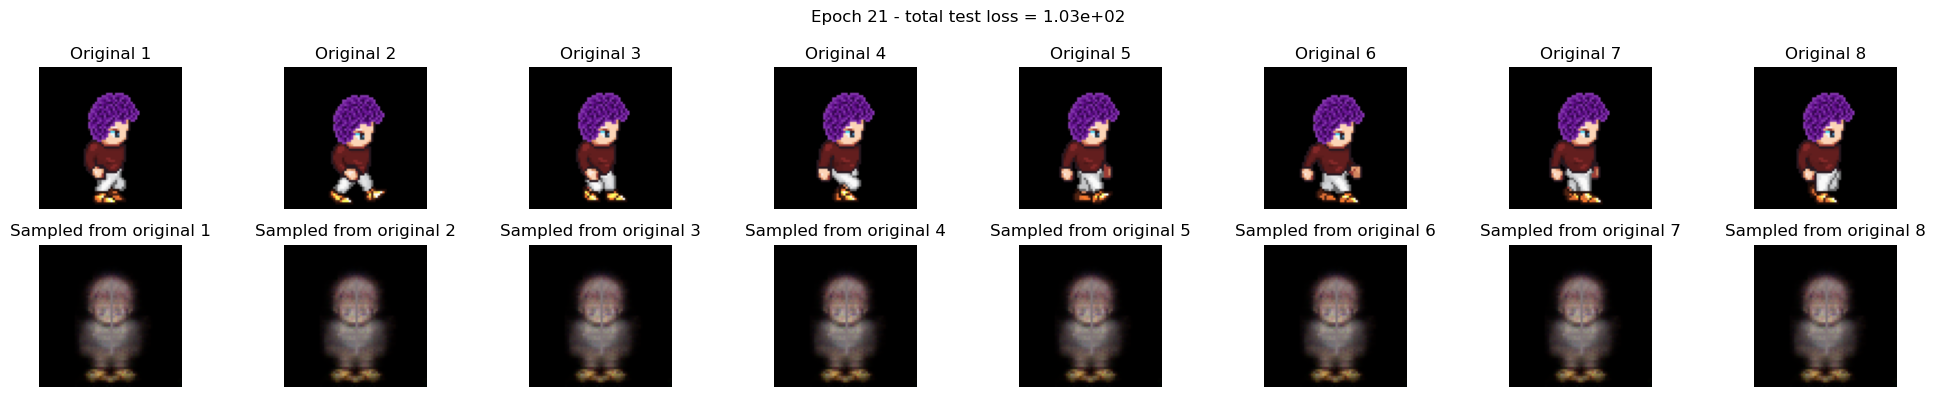

Epoch [22     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.8119e+02 (Rec VRNN) -6.3809e+00 (KL) 2.9027e+01 (Rec CNN) 2.8757e+02 -- TEST : (Total) 1.0285e+02 (Rec VRNN) -2.2983e+00 (KL) 9.7405e+00 (Rec CNN) 9.5407e+01 -- Early stopping counter: 0 / 20
Epoch [23     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.8026e+02 (Rec VRNN) -7.2976e+00 (KL) 2.9394e+01 (Rec CNN) 2.8756e+02 -- TEST : (Total) 1.0276e+02 (Rec VRNN) -2.4504e+00 (KL) 9.8608e+00 (Rec CNN) 9.5346e+01 -- Early stopping counter: 0 / 20
Epoch [24     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.7919e+02 (Rec VRNN) -8.1179e+00 (KL) 2.9746e+01 (Rec CNN) 2.8731e+02 -- TEST : (Total) 1.0237e+02 (Rec VRNN) -2.8879e+00 (KL) 9.9751e+00 (Rec CNN) 9.5288e+01 -- Early stopping counter: 0 / 20
Epoch [25     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.7796e+02 (Rec VRNN) -9.0872e+00 (KL) 3.0091e+01 (Rec CNN) 2.8705e+02 -- TEST : (Total) 1.0217e+02 (Rec VRNN) -3.1395e+00 (KL) 1.0091e+01 (Rec CNN) 9.5221e+01 -- Early stopp

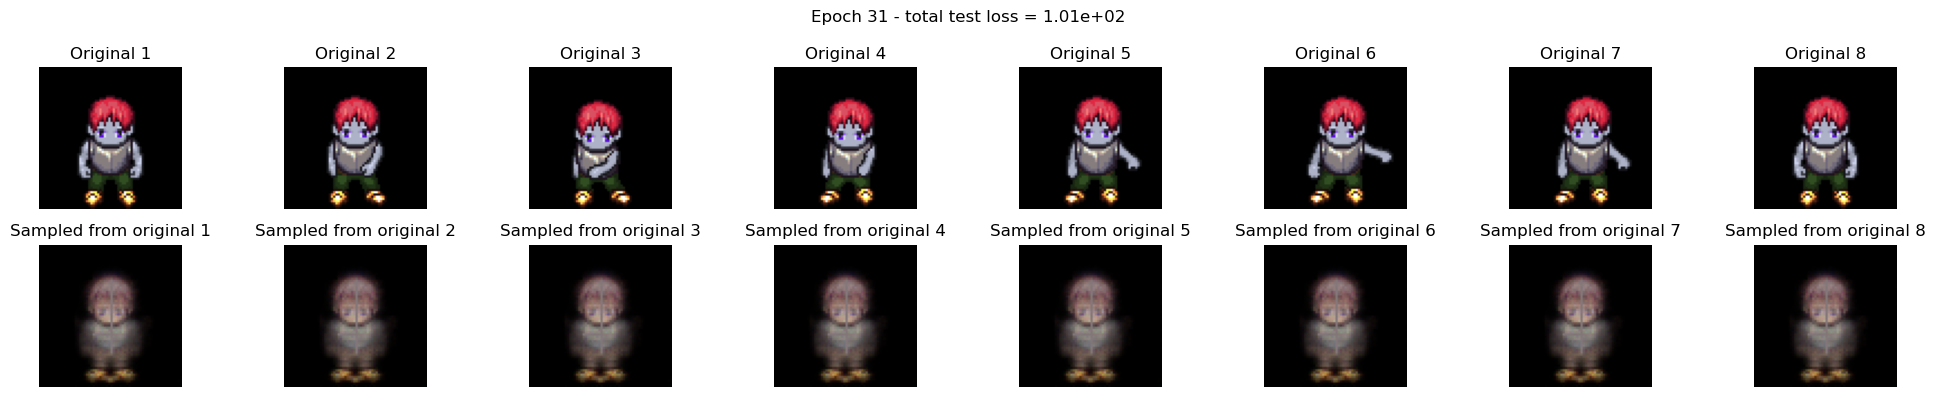

Epoch [32     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.7111e+02 (Rec VRNN) -1.5449e+01 (KL) 3.2081e+01 (Rec CNN) 2.8656e+02 -- TEST : (Total) 1.0044e+02 (Rec VRNN) -5.3540e+00 (KL) 1.0735e+01 (Rec CNN) 9.5062e+01 -- Early stopping counter: 0 / 20
Epoch [33     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.7018e+02 (Rec VRNN) -1.6540e+01 (KL) 3.2322e+01 (Rec CNN) 2.8672e+02 -- TEST : (Total) 1.0017e+02 (Rec VRNN) -5.6913e+00 (KL) 1.0817e+01 (Rec CNN) 9.5041e+01 -- Early stopping counter: 0 / 20
Epoch [34     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.7110e+02 (Rec VRNN) -1.5341e+01 (KL) 3.2543e+01 (Rec CNN) 2.8644e+02 -- TEST : (Total) 1.0044e+02 (Rec VRNN) -5.4714e+00 (KL) 1.0874e+01 (Rec CNN) 9.5035e+01 -- Early stopping counter: 1 / 20
Epoch [35     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.6888e+02 (Rec VRNN) -1.7713e+01 (KL) 3.2702e+01 (Rec CNN) 2.8659e+02 -- TEST : (Total) 9.9866e+01 (Rec VRNN) -6.1394e+00 (KL) 1.0934e+01 (Rec CNN) 9.5071e+01 -- Early stopp

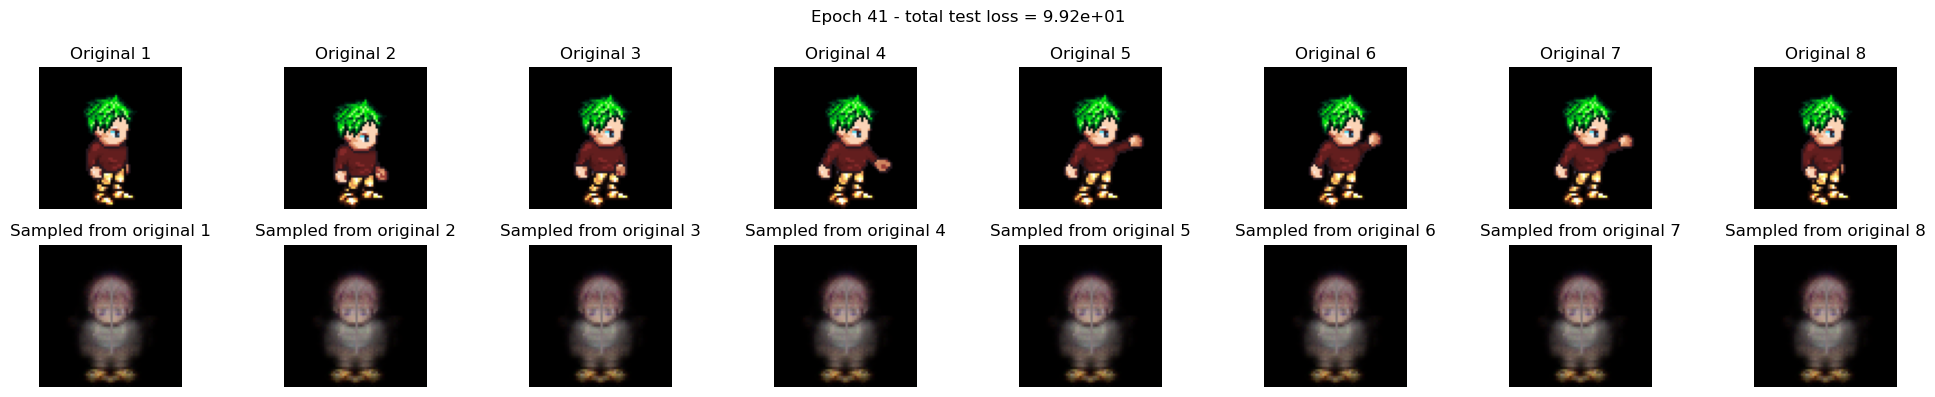

Epoch [42     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.6408e+02 (Rec VRNN) -2.1968e+01 (KL) 3.3790e+01 (Rec CNN) 2.8605e+02 -- TEST : (Total) 9.8557e+01 (Rec VRNN) -7.6268e+00 (KL) 1.1288e+01 (Rec CNN) 9.4895e+01 -- Early stopping counter: 0 / 20
Epoch [43     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.6277e+02 (Rec VRNN) -2.3296e+01 (KL) 3.3955e+01 (Rec CNN) 2.8606e+02 -- TEST : (Total) 9.8287e+01 (Rec VRNN) -7.9590e+00 (KL) 1.1354e+01 (Rec CNN) 9.4892e+01 -- Early stopping counter: 0 / 20
Epoch [44     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.6171e+02 (Rec VRNN) -2.4335e+01 (KL) 3.4161e+01 (Rec CNN) 2.8604e+02 -- TEST : (Total) 9.8002e+01 (Rec VRNN) -8.2825e+00 (KL) 1.1424e+01 (Rec CNN) 9.4860e+01 -- Early stopping counter: 0 / 20
Epoch [45     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.7192e+02 (Rec VRNN) -1.4043e+01 (KL) 3.4303e+01 (Rec CNN) 2.8596e+02 -- TEST : (Total) 1.0049e+02 (Rec VRNN) -5.7694e+00 (KL) 1.1408e+01 (Rec CNN) 9.4852e+01 -- Early stopp

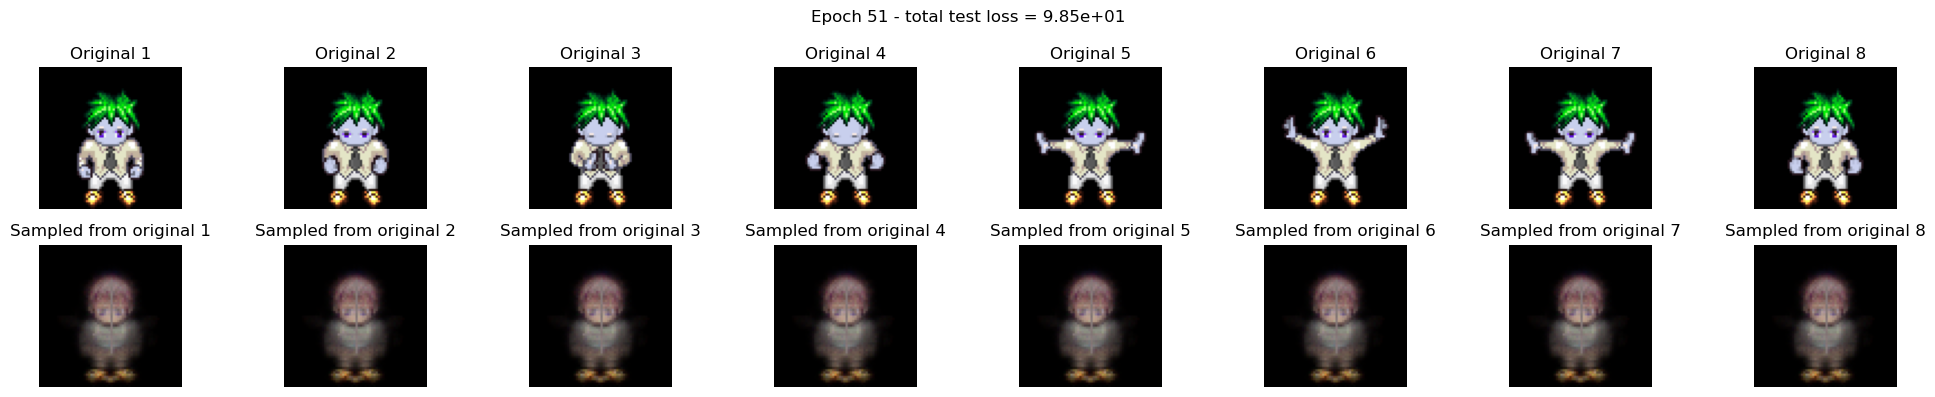

Epoch [52     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.6008e+02 (Rec VRNN) -2.5845e+01 (KL) 3.4926e+01 (Rec CNN) 2.8593e+02 -- TEST : (Total) 9.7608e+01 (Rec VRNN) -8.8670e+00 (KL) 1.1665e+01 (Rec CNN) 9.4810e+01 -- Early stopping counter: 3 / 20
Epoch [53     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.5868e+02 (Rec VRNN) -2.7134e+01 (KL) 3.5080e+01 (Rec CNN) 2.8581e+02 -- TEST : (Total) 9.7320e+01 (Rec VRNN) -9.2156e+00 (KL) 1.1726e+01 (Rec CNN) 9.4809e+01 -- Early stopping counter: 0 / 20
Epoch [54     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.5775e+02 (Rec VRNN) -2.8036e+01 (KL) 3.5270e+01 (Rec CNN) 2.8579e+02 -- TEST : (Total) 9.7115e+01 (Rec VRNN) -9.4840e+00 (KL) 1.1791e+01 (Rec CNN) 9.4808e+01 -- Early stopping counter: 0 / 20
Epoch [55     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.7418e+02 (Rec VRNN) -1.1704e+01 (KL) 3.5410e+01 (Rec CNN) 2.8589e+02 -- TEST : (Total) 1.0193e+02 (Rec VRNN) -4.6824e+00 (KL) 1.1767e+01 (Rec CNN) 9.4841e+01 -- Early stopp

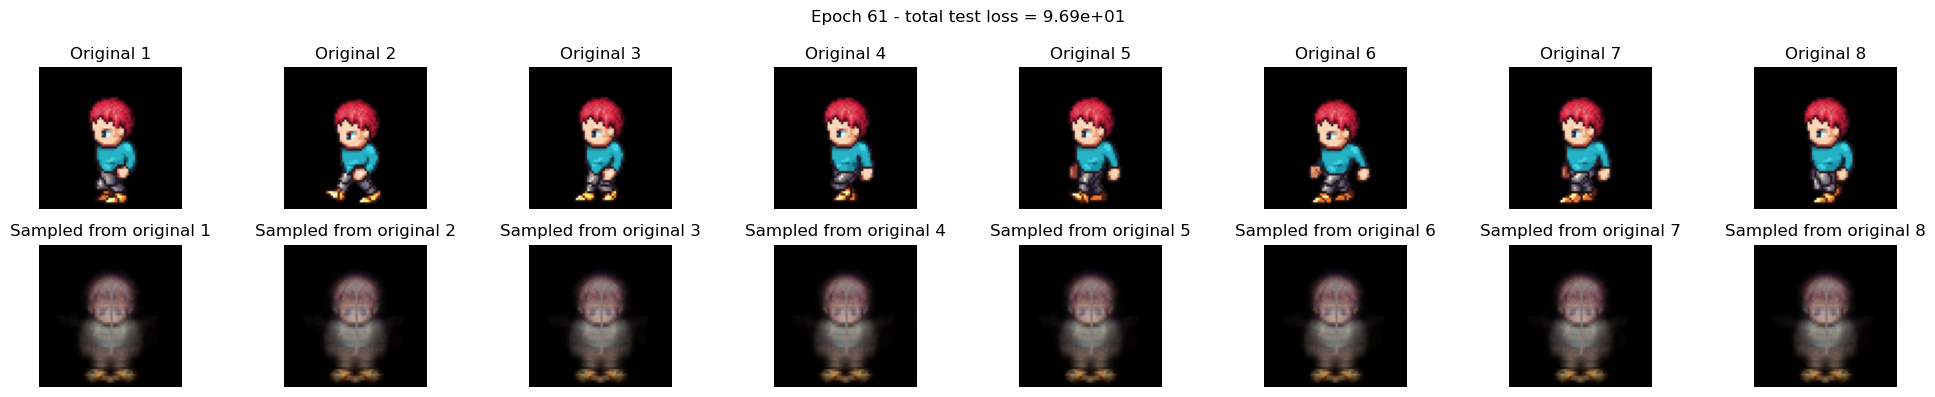

Epoch [62     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.5584e+02 (Rec VRNN) -2.9990e+01 (KL) 3.6112e+01 (Rec CNN) 2.8583e+02 -- TEST : (Total) 9.6794e+01 (Rec VRNN) -1.0037e+01 (KL) 1.2071e+01 (Rec CNN) 9.4760e+01 -- Early stopping counter: 0 / 20
Epoch [63     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.9443e+02 (Rec VRNN) 8.7527e+00 (KL) 3.6032e+01 (Rec CNN) 2.8568e+02 -- TEST : (Total) 9.9664e+01 (Rec VRNN) -6.9734e+00 (KL) 1.1877e+01 (Rec CNN) 9.4761e+01 -- Early stopping counter: 1 / 20
Epoch [64     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.6202e+02 (Rec VRNN) -2.3589e+01 (KL) 3.5465e+01 (Rec CNN) 2.8561e+02 -- TEST : (Total) 9.7556e+01 (Rec VRNN) -8.9902e+00 (KL) 1.1793e+01 (Rec CNN) 9.4754e+01 -- Early stopping counter: 2 / 20
Epoch [65     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.5894e+02 (Rec VRNN) -2.6776e+01 (KL) 3.5423e+01 (Rec CNN) 2.8572e+02 -- TEST : (Total) 9.7549e+01 (Rec VRNN) -9.0667e+00 (KL) 1.1834e+01 (Rec CNN) 9.4782e+01 -- Early stoppi

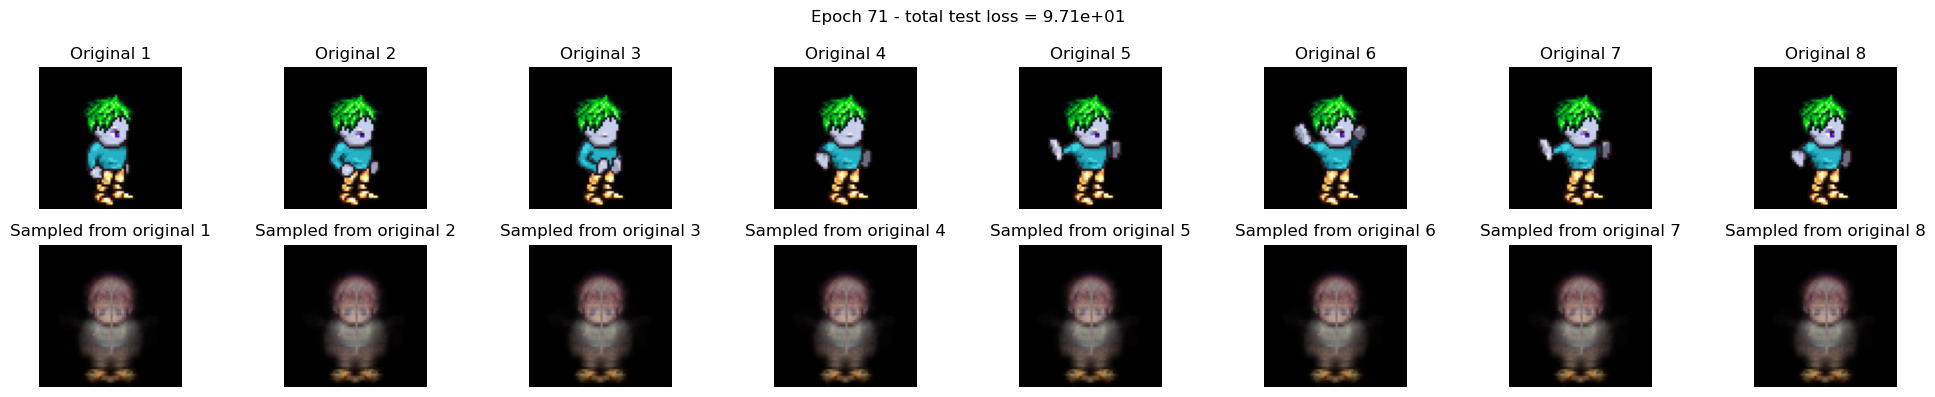

Epoch [72     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.5562e+02 (Rec VRNN) -3.0040e+01 (KL) 3.6840e+01 (Rec CNN) 2.8566e+02 -- TEST : (Total) 9.6952e+01 (Rec VRNN) -1.0090e+01 (KL) 1.2314e+01 (Rec CNN) 9.4728e+01 -- Early stopping counter: 10 / 20
Epoch [73     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.5501e+02 (Rec VRNN) -3.0477e+01 (KL) 3.7028e+01 (Rec CNN) 2.8549e+02 -- TEST : (Total) 9.6875e+01 (Rec VRNN) -1.0236e+01 (KL) 1.2375e+01 (Rec CNN) 9.4736e+01 -- Early stopping counter: 11 / 20
Epoch [74     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.5468e+02 (Rec VRNN) -3.0918e+01 (KL) 3.7208e+01 (Rec CNN) 2.8560e+02 -- TEST : (Total) 9.6774e+01 (Rec VRNN) -1.0384e+01 (KL) 1.2433e+01 (Rec CNN) 9.4725e+01 -- Early stopping counter: 0 / 20
Epoch [75     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.5896e+02 (Rec VRNN) -2.6762e+01 (KL) 3.7382e+01 (Rec CNN) 2.8573e+02 -- TEST : (Total) 1.4287e+02 (Rec VRNN) 3.5680e+01 (KL) 1.2478e+01 (Rec CNN) 9.4711e+01 -- Early stop

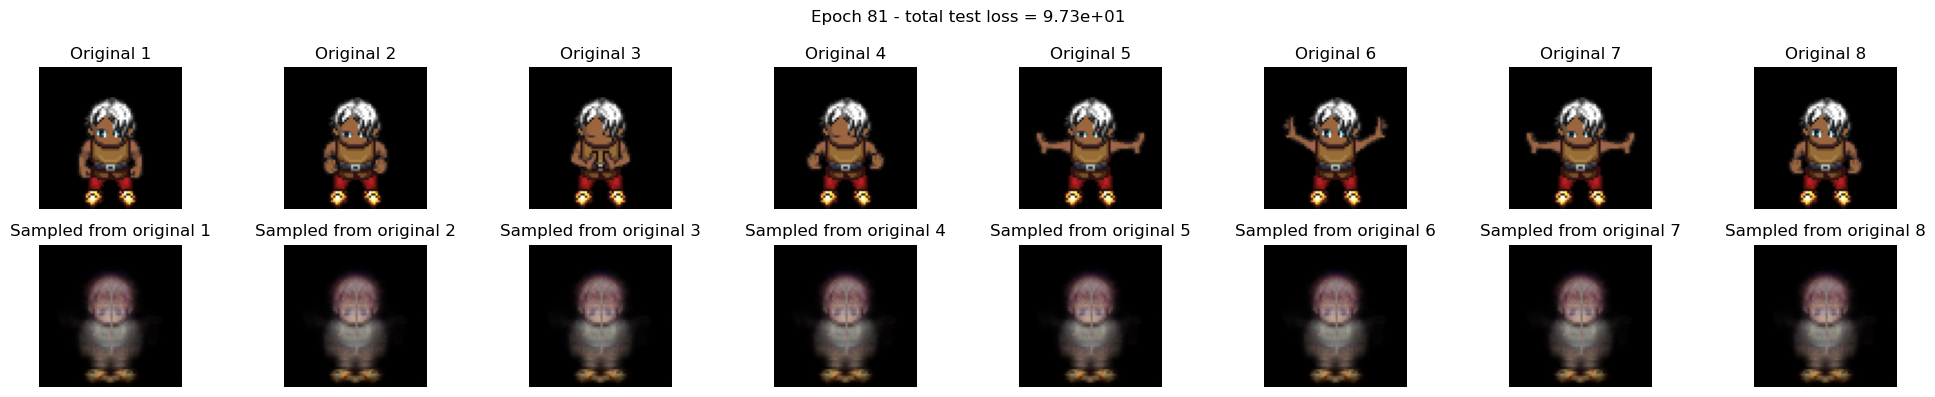

Epoch [82     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.5576e+02 (Rec VRNN) -2.9749e+01 (KL) 3.7289e+01 (Rec CNN) 2.8551e+02 -- TEST : (Total) 9.7186e+01 (Rec VRNN) -9.9775e+00 (KL) 1.2462e+01 (Rec CNN) 9.4702e+01 -- Early stopping counter: 8 / 20
Epoch [83     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.5554e+02 (Rec VRNN) -3.0098e+01 (KL) 3.7468e+01 (Rec CNN) 2.8563e+02 -- TEST : (Total) 9.7116e+01 (Rec VRNN) -1.0094e+01 (KL) 1.2520e+01 (Rec CNN) 9.4690e+01 -- Early stopping counter: 9 / 20
Epoch [84     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.5508e+02 (Rec VRNN) -3.0450e+01 (KL) 3.7640e+01 (Rec CNN) 2.8553e+02 -- TEST : (Total) 9.7064e+01 (Rec VRNN) -1.0212e+01 (KL) 1.2576e+01 (Rec CNN) 9.4700e+01 -- Early stopping counter: 10 / 20
Epoch [85     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.5468e+02 (Rec VRNN) -3.0806e+01 (KL) 3.7807e+01 (Rec CNN) 2.8548e+02 -- TEST : (Total) 9.6979e+01 (Rec VRNN) -1.0332e+01 (KL) 1.2631e+01 (Rec CNN) 9.4680e+01 -- Early stop

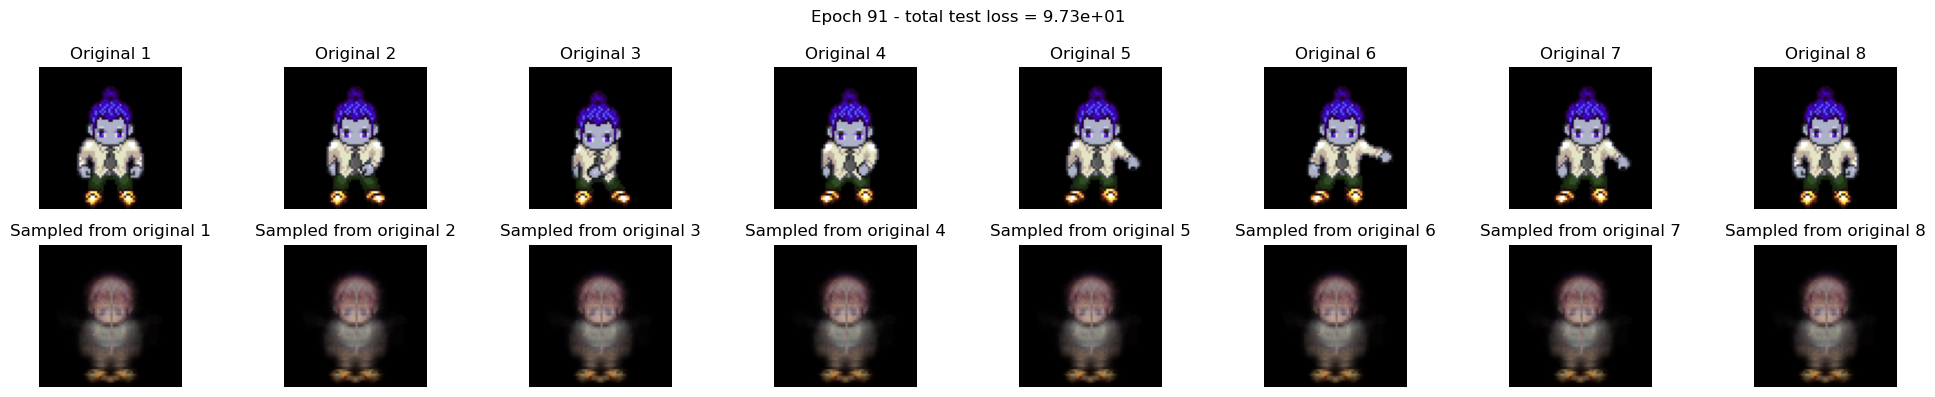

Epoch [92     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.5413e+02 (Rec VRNN) -3.1286e+01 (KL) 3.8392e+01 (Rec CNN) 2.8542e+02 -- TEST : (Total) 9.6975e+01 (Rec VRNN) -1.0550e+01 (KL) 1.2815e+01 (Rec CNN) 9.4710e+01 -- Early stopping counter: 3 / 20
Epoch [93     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.6261e+02 (Rec VRNN) -2.2816e+01 (KL) 3.8470e+01 (Rec CNN) 2.8542e+02 -- TEST : (Total) 9.7557e+01 (Rec VRNN) -9.9586e+00 (KL) 1.2812e+01 (Rec CNN) 9.4704e+01 -- Early stopping counter: 4 / 20
Epoch [94     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.5565e+02 (Rec VRNN) -2.9819e+01 (KL) 3.8427e+01 (Rec CNN) 2.8547e+02 -- TEST : (Total) 9.6952e+01 (Rec VRNN) -1.0558e+01 (KL) 1.2814e+01 (Rec CNN) 9.4696e+01 -- Early stopping counter: 5 / 20
Epoch [95     .../... 300   ] beta = 0.00 -- TRAIN : (Total) 2.5405e+02 (Rec VRNN) -3.1549e+01 (KL) 3.8494e+01 (Rec CNN) 2.8560e+02 -- TEST : (Total) 9.6931e+01 (Rec VRNN) -1.0589e+01 (KL) 1.2854e+01 (Rec CNN) 9.4665e+01 -- Early stopp

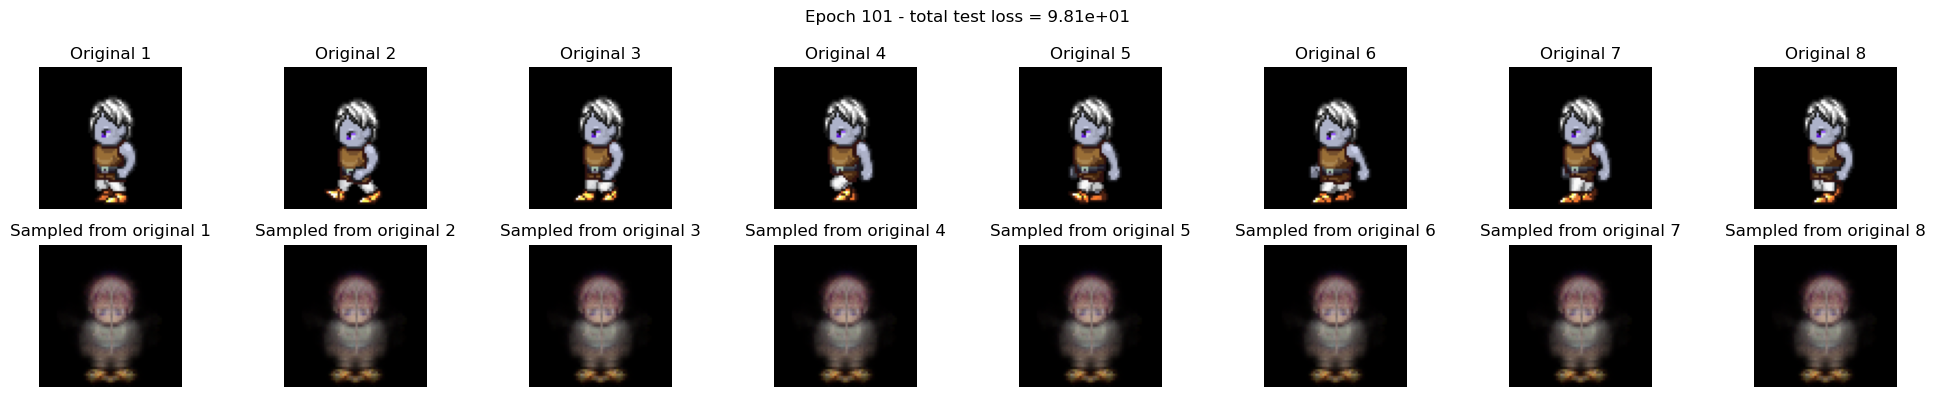

Epoch [102    .../... 300   ] beta = 0.01 -- TRAIN : (Total) 2.5538e+02 (Rec VRNN) -3.0334e+01 (KL) 1.6778e+01 (Rec CNN) 2.8554e+02 -- TEST : (Total) 8.5438e+01 (Rec VRNN) -1.0295e+01 (KL) 9.9197e-01 (Rec CNN) 9.4742e+01 -- Early stopping counter: 0 / 20
Epoch [103    .../... 300   ] beta = 0.02 -- TRAIN : (Total) 2.5437e+02 (Rec VRNN) -3.1086e+01 (KL) 1.1129e+00 (Rec CNN) 2.8543e+02 -- TEST : (Total) 8.4338e+01 (Rec VRNN) -1.0437e+01 (KL) 1.1231e-01 (Rec CNN) 9.4663e+01 -- Early stopping counter: 0 / 20
Epoch [104    .../... 300   ] beta = 0.03 -- TRAIN : (Total) 2.5392e+02 (Rec VRNN) -3.1450e+01 (KL) 1.6965e-01 (Rec CNN) 2.8537e+02 -- TEST : (Total) 8.4171e+01 (Rec VRNN) -1.0540e+01 (KL) 2.1824e-02 (Rec CNN) 9.4689e+01 -- Early stopping counter: 0 / 20
Epoch [105    .../... 300   ] beta = 0.04 -- TRAIN : (Total) 2.5361e+02 (Rec VRNN) -3.1766e+01 (KL) 3.6727e-02 (Rec CNN) 2.8537e+02 -- TEST : (Total) 8.4057e+01 (Rec VRNN) -1.0643e+01 (KL) 6.4847e-03 (Rec CNN) 9.4693e+01 -- Early stopp

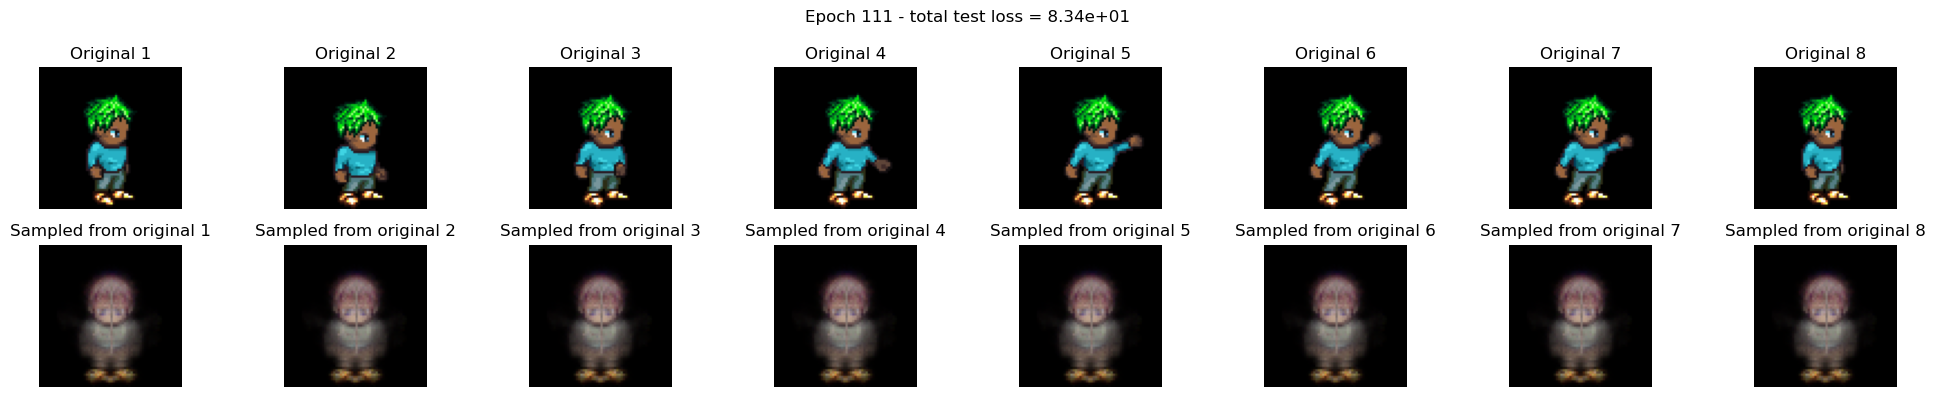

Epoch [112    .../... 300   ] beta = 0.11 -- TRAIN : (Total) 2.5156e+02 (Rec VRNN) -3.3964e+01 (KL) 1.3335e-03 (Rec CNN) 2.8552e+02 -- TEST : (Total) 8.3645e+01 (Rec VRNN) -1.1011e+01 (KL) 3.7988e-04 (Rec CNN) 9.4655e+01 -- Early stopping counter: 1 / 20
Epoch [113    .../... 300   ] beta = 0.12 -- TRAIN : (Total) 2.9456e+02 (Rec VRNN) 9.1389e+00 (KL) 1.0858e-03 (Rec CNN) 2.8542e+02 -- TEST : (Total) 8.6465e+01 (Rec VRNN) -8.2256e+00 (KL) 3.5357e-04 (Rec CNN) 9.4690e+01 -- Early stopping counter: 2 / 20
Epoch [114    .../... 300   ] beta = 0.13 -- TRAIN : (Total) 2.5796e+02 (Rec VRNN) -2.7343e+01 (KL) 8.3949e-04 (Rec CNN) 2.8530e+02 -- TEST : (Total) 8.4503e+01 (Rec VRNN) -1.0145e+01 (KL) 2.2389e-04 (Rec CNN) 9.4648e+01 -- Early stopping counter: 3 / 20
Epoch [115    .../... 300   ] beta = 0.14 -- TRAIN : (Total) 2.5426e+02 (Rec VRNN) -3.1083e+01 (KL) 5.9027e-04 (Rec CNN) 2.8535e+02 -- TEST : (Total) 8.4132e+01 (Rec VRNN) -1.0530e+01 (KL) 1.6641e-04 (Rec CNN) 9.4662e+01 -- Early stoppi

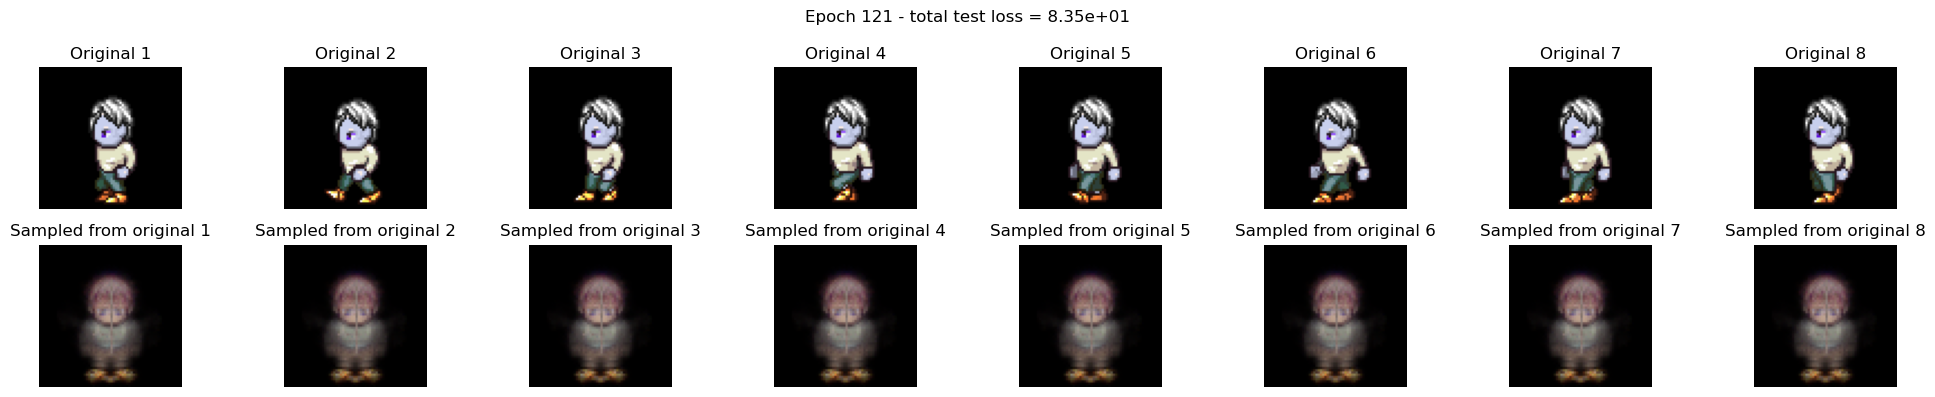

Epoch [122    .../... 300   ] beta = 0.21 -- TRAIN : (Total) 2.5188e+02 (Rec VRNN) -3.3554e+01 (KL) 8.4350e-05 (Rec CNN) 2.8544e+02 -- TEST : (Total) 8.3440e+01 (Rec VRNN) -1.1237e+01 (KL) 2.3974e-05 (Rec CNN) 9.4677e+01 -- Early stopping counter: 11 / 20
Epoch [123    .../... 300   ] beta = 0.22 -- TRAIN : (Total) 2.5147e+02 (Rec VRNN) -3.3851e+01 (KL) 6.2765e-05 (Rec CNN) 2.8533e+02 -- TEST : (Total) 8.3316e+01 (Rec VRNN) -1.1336e+01 (KL) 1.8159e-05 (Rec CNN) 9.4652e+01 -- Early stopping counter: 0 / 20
Epoch [124    .../... 300   ] beta = 0.23 -- TRAIN : (Total) 2.5131e+02 (Rec VRNN) -3.4151e+01 (KL) 4.7716e-05 (Rec CNN) 2.8546e+02 -- TEST : (Total) 8.3223e+01 (Rec VRNN) -1.1437e+01 (KL) 1.3390e-05 (Rec CNN) 9.4660e+01 -- Early stopping counter: 0 / 20
Epoch [125    .../... 300   ] beta = 0.24 -- TRAIN : (Total) 2.5082e+02 (Rec VRNN) -3.4443e+01 (KL) 3.5059e-05 (Rec CNN) 2.8526e+02 -- TEST : (Total) 8.3220e+01 (Rec VRNN) -1.1445e+01 (KL) 1.0185e-05 (Rec CNN) 9.4665e+01 -- Early stop

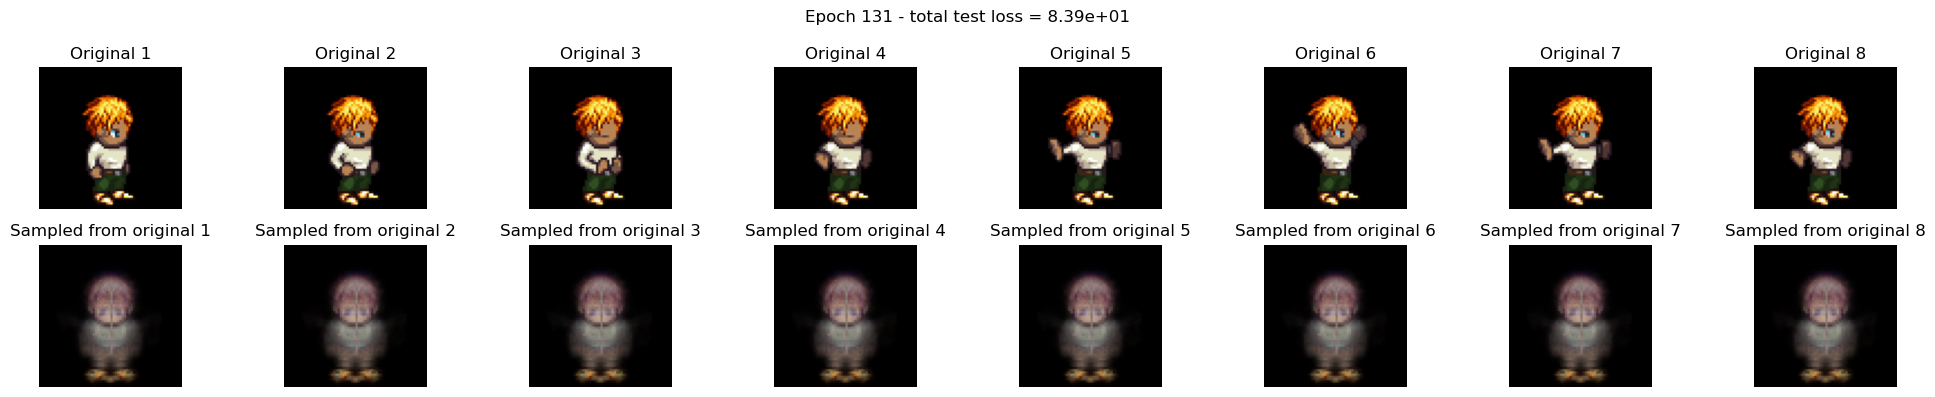

Epoch [132    .../... 300   ] beta = 0.31 -- TRAIN : (Total) 2.5295e+02 (Rec VRNN) -3.2445e+01 (KL) 4.3201e-06 (Rec CNN) 2.8539e+02 -- TEST : (Total) 8.3782e+01 (Rec VRNN) -1.0860e+01 (KL) 1.2631e-06 (Rec CNN) 9.4642e+01 -- Early stopping counter: 7 / 20
Epoch [133    .../... 300   ] beta = 0.32 -- TRAIN : (Total) 2.5267e+02 (Rec VRNN) -3.2704e+01 (KL) 3.4148e-06 (Rec CNN) 2.8538e+02 -- TEST : (Total) 8.3704e+01 (Rec VRNN) -1.0947e+01 (KL) 1.0404e-06 (Rec CNN) 9.4651e+01 -- Early stopping counter: 8 / 20
Epoch [134    .../... 300   ] beta = 0.33 -- TRAIN : (Total) 2.5253e+02 (Rec VRNN) -3.2965e+01 (KL) 2.6406e-06 (Rec CNN) 2.8549e+02 -- TEST : (Total) 8.3767e+01 (Rec VRNN) -1.1035e+01 (KL) 7.3621e-07 (Rec CNN) 9.4801e+01 -- Early stopping counter: 9 / 20
Epoch [135    .../... 300   ] beta = 0.34 -- TRAIN : (Total) 2.5222e+02 (Rec VRNN) -3.3229e+01 (KL) 2.1892e-06 (Rec CNN) 2.8545e+02 -- TEST : (Total) 8.3547e+01 (Rec VRNN) -1.1123e+01 (KL) 6.0631e-07 (Rec CNN) 9.4670e+01 -- Early stopp

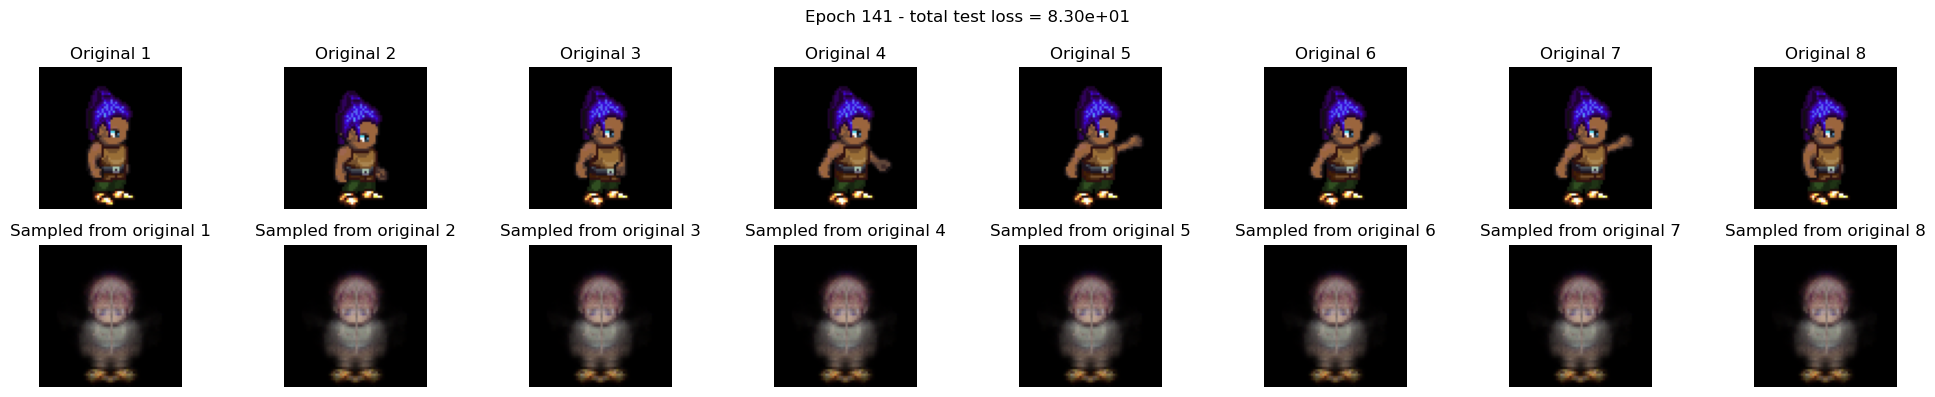

Epoch [142    .../... 300   ] beta = 0.41 -- TRAIN : (Total) 2.5036e+02 (Rec VRNN) -3.5136e+01 (KL) 7.5157e-07 (Rec CNN) 2.8550e+02 -- TEST : (Total) 8.2988e+01 (Rec VRNN) -1.1670e+01 (KL) 2.7340e-07 (Rec CNN) 9.4659e+01 -- Early stopping counter: 1 / 20
Epoch [143    .../... 300   ] beta = 0.42 -- TRAIN : (Total) 2.8476e+02 (Rec VRNN) -5.0360e-01 (KL) 1.9676e-04 (Rec CNN) 2.8526e+02 -- TEST : (Total) 8.6353e+01 (Rec VRNN) -8.2975e+00 (KL) 1.1799e-04 (Rec CNN) 9.4650e+01 -- Early stopping counter: 2 / 20
Epoch [144    .../... 300   ] beta = 0.43 -- TRAIN : (Total) 2.5633e+02 (Rec VRNN) -2.9116e+01 (KL) 1.4742e-04 (Rec CNN) 2.8545e+02 -- TEST : (Total) 8.3918e+01 (Rec VRNN) -1.0712e+01 (KL) 1.7380e-05 (Rec CNN) 9.4630e+01 -- Early stopping counter: 3 / 20
Epoch [145    .../... 300   ] beta = 0.44 -- TRAIN : (Total) 2.5241e+02 (Rec VRNN) -3.2981e+01 (KL) 3.8517e-05 (Rec CNN) 2.8539e+02 -- TEST : (Total) 8.3517e+01 (Rec VRNN) -1.1116e+01 (KL) 1.6701e-06 (Rec CNN) 9.4632e+01 -- Early stopp

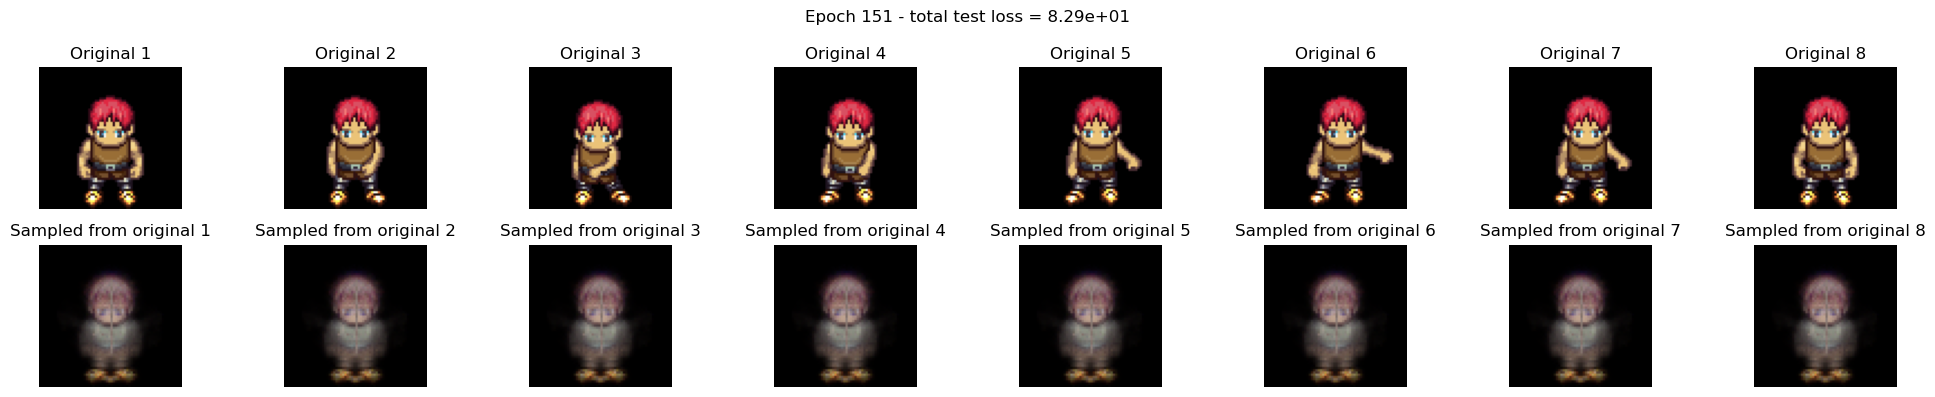

Epoch [152    .../... 300   ] beta = 0.51 -- TRAIN : (Total) 3.0151e+02 (Rec VRNN) 1.6213e+01 (KL) 2.5145e-04 (Rec CNN) 2.8530e+02 -- TEST : (Total) 1.0592e+02 (Rec VRNN) 1.1275e+01 (KL) 6.0331e-05 (Rec CNN) 9.4647e+01 -- Early stopping counter: 1 / 20
Epoch [153    .../... 300   ] beta = 0.52 -- TRAIN : (Total) 2.6833e+02 (Rec VRNN) -1.6951e+01 (KL) 5.5377e-04 (Rec CNN) 2.8528e+02 -- TEST : (Total) 8.4558e+01 (Rec VRNN) -1.0078e+01 (KL) 6.4106e-05 (Rec CNN) 9.4636e+01 -- Early stopping counter: 2 / 20
Epoch [154    .../... 300   ] beta = 0.53 -- TRAIN : (Total) 2.5458e+02 (Rec VRNN) -3.0709e+01 (KL) 1.1174e-04 (Rec CNN) 2.8529e+02 -- TEST : (Total) 8.4122e+01 (Rec VRNN) -1.0517e+01 (KL) 1.2308e-05 (Rec CNN) 9.4639e+01 -- Early stopping counter: 3 / 20
Epoch [155    .../... 300   ] beta = 0.54 -- TRAIN : (Total) 2.5309e+02 (Rec VRNN) -3.2163e+01 (KL) 1.9674e-05 (Rec CNN) 2.8526e+02 -- TEST : (Total) 8.3823e+01 (Rec VRNN) -1.0815e+01 (KL) 2.5739e-06 (Rec CNN) 9.4638e+01 -- Early stoppin

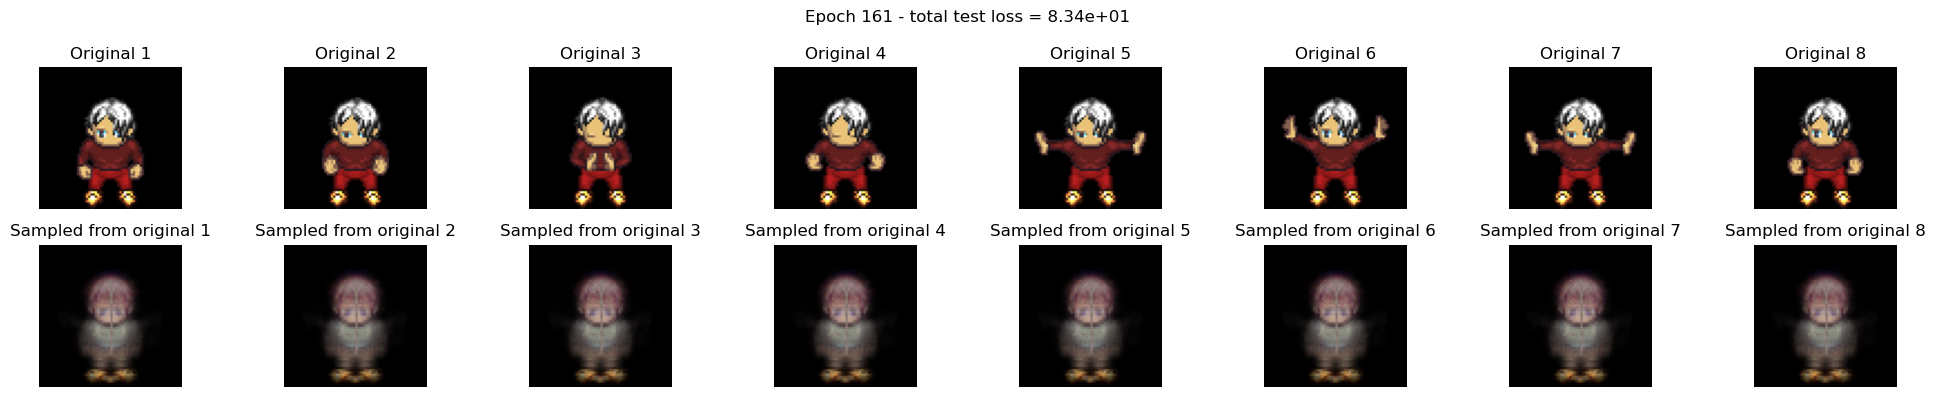

Epoch [162    .../... 300   ] beta = 0.61 -- TRAIN : (Total) 2.5149e+02 (Rec VRNN) -3.3909e+01 (KL) 1.8997e-07 (Rec CNN) 2.8540e+02 -- TEST : (Total) 8.3304e+01 (Rec VRNN) -1.1343e+01 (KL) 7.1184e-08 (Rec CNN) 9.4647e+01 -- Early stopping counter: 11 / 20
Epoch [163    .../... 300   ] beta = 0.62 -- TRAIN : (Total) 2.5115e+02 (Rec VRNN) -3.4137e+01 (KL) 1.8372e-07 (Rec CNN) 2.8528e+02 -- TEST : (Total) 8.3214e+01 (Rec VRNN) -1.1419e+01 (KL) 5.9397e-08 (Rec CNN) 9.4633e+01 -- Early stopping counter: 12 / 20
Epoch [164    .../... 300   ] beta = 0.63 -- TRAIN : (Total) 2.5098e+02 (Rec VRNN) -3.4368e+01 (KL) 1.6672e-07 (Rec CNN) 2.8535e+02 -- TEST : (Total) 8.3152e+01 (Rec VRNN) -1.1497e+01 (KL) 5.5503e-08 (Rec CNN) 9.4649e+01 -- Early stopping counter: 13 / 20
Epoch [165    .../... 300   ] beta = 0.64 -- TRAIN : (Total) 2.5060e+02 (Rec VRNN) -3.4600e+01 (KL) 1.5860e-07 (Rec CNN) 2.8520e+02 -- TEST : (Total) 8.3043e+01 (Rec VRNN) -1.1575e+01 (KL) 5.6538e-08 (Rec CNN) 9.4618e+01 -- Early st

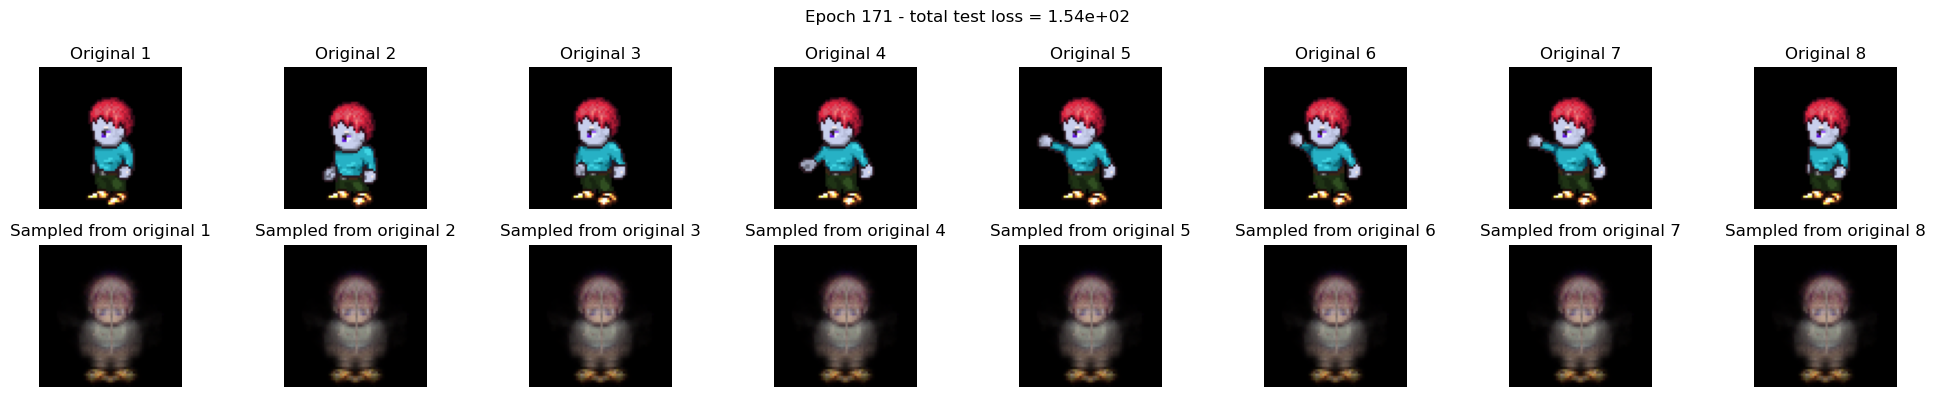

Epoch [172    .../... 300   ] beta = 0.71 -- TRAIN : (Total) 2.9597e+02 (Rec VRNN) 1.0529e+01 (KL) 8.7590e-04 (Rec CNN) 2.8544e+02 -- TEST : (Total) 8.4492e+01 (Rec VRNN) -1.0134e+01 (KL) 1.2131e-04 (Rec CNN) 9.4625e+01 -- Early stopping counter: 2 / 20
Epoch [173    .../... 300   ] beta = 0.72 -- TRAIN : (Total) 2.5602e+02 (Rec VRNN) -2.9285e+01 (KL) 1.8392e-04 (Rec CNN) 2.8531e+02 -- TEST : (Total) 8.4442e+01 (Rec VRNN) -1.0192e+01 (KL) 2.3372e-05 (Rec CNN) 9.4634e+01 -- Early stopping counter: 3 / 20
Epoch [174    .../... 300   ] beta = 0.73 -- TRAIN : (Total) 2.5306e+02 (Rec VRNN) -3.2148e+01 (KL) 3.2581e-05 (Rec CNN) 2.8521e+02 -- TEST : (Total) 8.3758e+01 (Rec VRNN) -1.0876e+01 (KL) 3.9535e-06 (Rec CNN) 9.4634e+01 -- Early stopping counter: 4 / 20
Epoch [175    .../... 300   ] beta = 0.74 -- TRAIN : (Total) 2.5263e+02 (Rec VRNN) -3.2749e+01 (KL) 5.4482e-06 (Rec CNN) 2.8538e+02 -- TEST : (Total) 8.3691e+01 (Rec VRNN) -1.0962e+01 (KL) 6.5731e-07 (Rec CNN) 9.4653e+01 -- Early stoppi

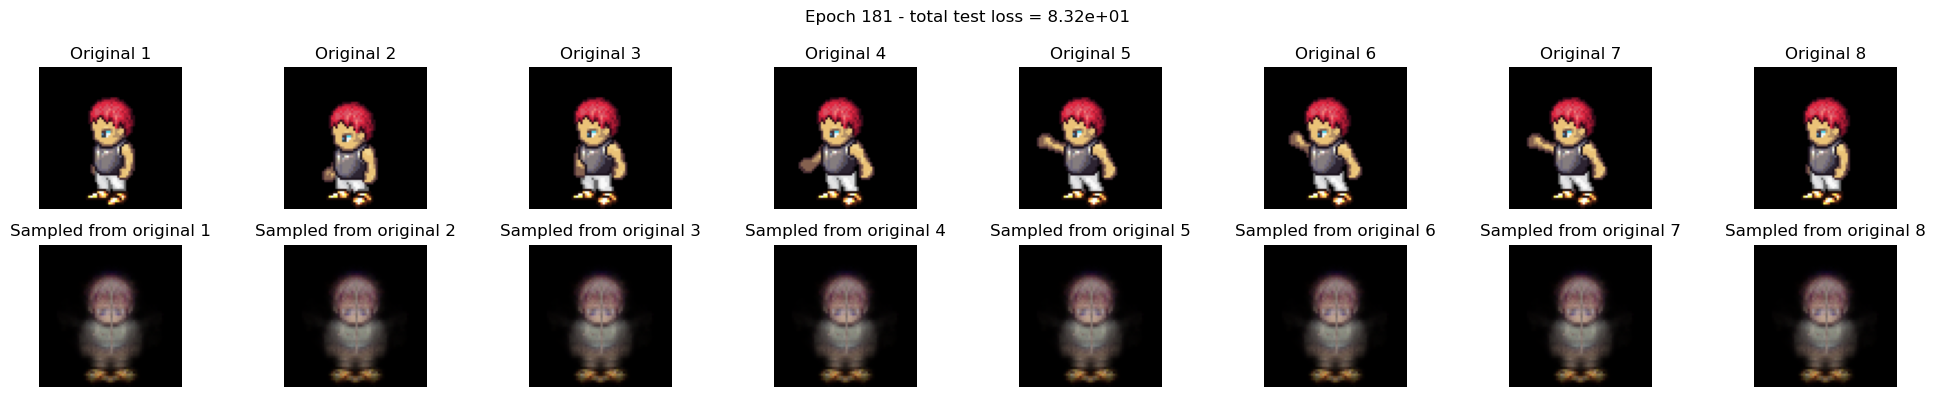

Epoch [182    .../... 300   ] beta = 0.81 -- TRAIN : (Total) 2.5111e+02 (Rec VRNN) -3.4239e+01 (KL) 8.3867e-08 (Rec CNN) 2.8534e+02 -- TEST : (Total) 8.3175e+01 (Rec VRNN) -1.1450e+01 (KL) 3.4571e-08 (Rec CNN) 9.4625e+01 -- Early stopping counter: 12 / 20
Epoch [183    .../... 300   ] beta = 0.82 -- TRAIN : (Total) 2.5080e+02 (Rec VRNN) -3.4451e+01 (KL) 7.2535e-08 (Rec CNN) 2.8525e+02 -- TEST : (Total) 8.3091e+01 (Rec VRNN) -1.1521e+01 (KL) 2.6723e-08 (Rec CNN) 9.4612e+01 -- Early stopping counter: 13 / 20
Epoch [184    .../... 300   ] beta = 0.83 -- TRAIN : (Total) 2.5065e+02 (Rec VRNN) -3.4665e+01 (KL) 7.3003e-08 (Rec CNN) 2.8531e+02 -- TEST : (Total) 8.3108e+01 (Rec VRNN) -1.1593e+01 (KL) 2.2340e-08 (Rec CNN) 9.4701e+01 -- Early stopping counter: 14 / 20
Epoch [185    .../... 300   ] beta = 0.84 -- TRAIN : (Total) 2.5042e+02 (Rec VRNN) -3.4880e+01 (KL) 6.8998e-08 (Rec CNN) 2.8530e+02 -- TEST : (Total) 8.2985e+01 (Rec VRNN) -1.1665e+01 (KL) 1.9251e-08 (Rec CNN) 9.4650e+01 -- Early st

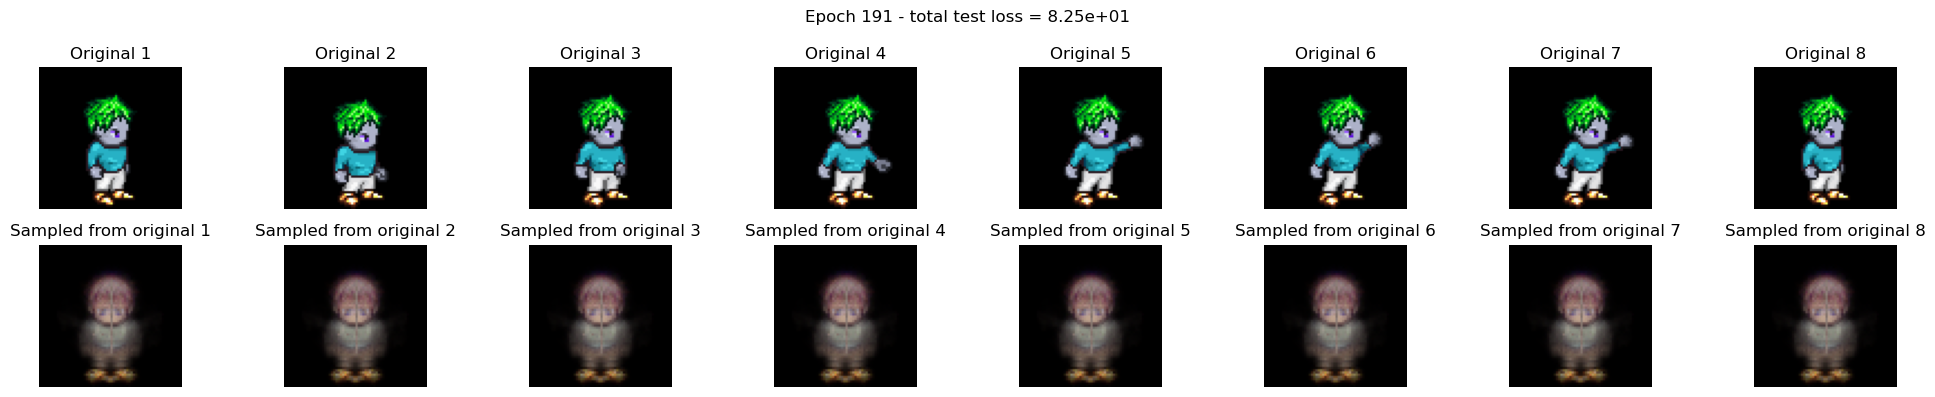

Epoch [192    .../... 300   ] beta = 0.91 -- TRAIN : (Total) 2.8984e+02 (Rec VRNN) 4.5194e+00 (KL) 1.6293e-04 (Rec CNN) 2.8532e+02 -- TEST : (Total) 9.4626e+01 (Rec VRNN) 4.0754e-03 (KL) 4.4295e-04 (Rec CNN) 9.4622e+01 -- Early stopping counter: 1 / 20
Epoch [193    .../... 300   ] beta = 0.92 -- TRAIN : (Total) 2.7979e+02 (Rec VRNN) -5.7789e+00 (KL) 7.7868e-04 (Rec CNN) 2.8557e+02 -- TEST : (Total) 8.7162e+01 (Rec VRNN) -7.4955e+00 (KL) 6.4967e-05 (Rec CNN) 9.4658e+01 -- Early stopping counter: 2 / 20
Epoch [194    .../... 300   ] beta = 0.93 -- TRAIN : (Total) 2.5487e+02 (Rec VRNN) -3.0523e+01 (KL) 1.3120e-04 (Rec CNN) 2.8539e+02 -- TEST : (Total) 8.3732e+01 (Rec VRNN) -1.0935e+01 (KL) 1.3501e-05 (Rec CNN) 9.4667e+01 -- Early stopping counter: 3 / 20
Epoch [195    .../... 300   ] beta = 0.94 -- TRAIN : (Total) 2.5241e+02 (Rec VRNN) -3.3104e+01 (KL) 2.0117e-05 (Rec CNN) 2.8551e+02 -- TEST : (Total) 8.3598e+01 (Rec VRNN) -1.1116e+01 (KL) 2.5821e-06 (Rec CNN) 9.4714e+01 -- Early stoppin

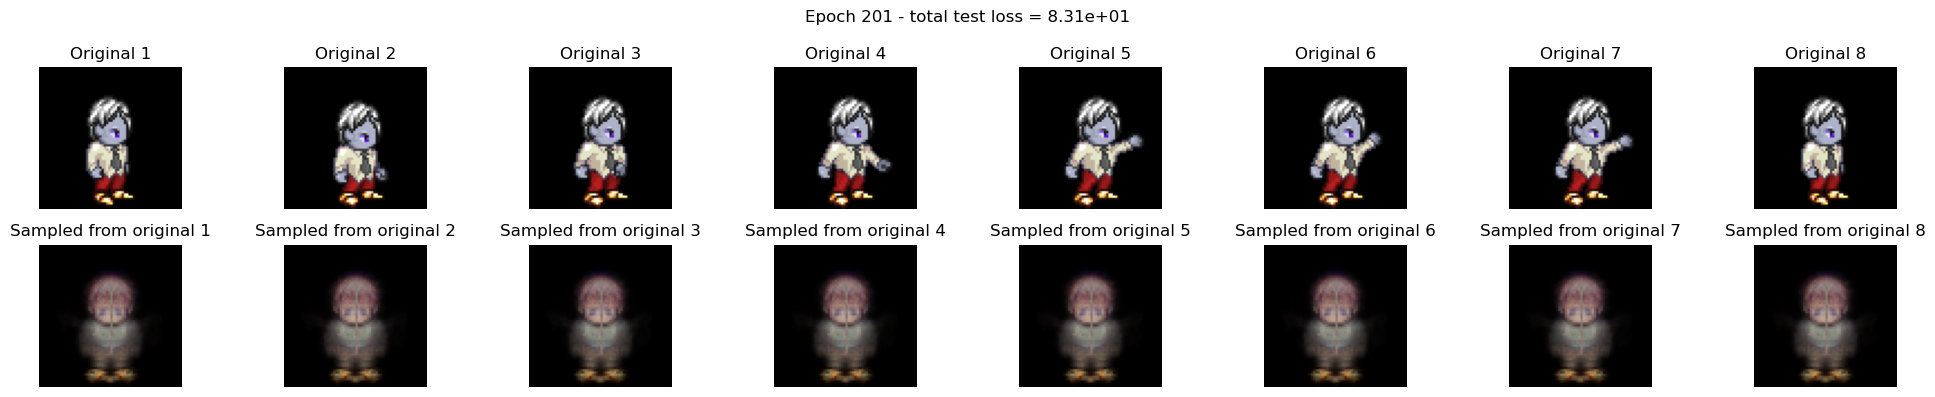

Epoch [202    .../... 300   ] beta = 1.00 -- TRAIN : (Total) 2.5047e+02 (Rec VRNN) -3.4862e+01 (KL) 3.6765e-08 (Rec CNN) 2.8534e+02 -- TEST : (Total) 8.2968e+01 (Rec VRNN) -1.1658e+01 (KL) 1.4437e-08 (Rec CNN) 9.4626e+01 -- Early stopping counter: 11 / 20
Epoch [203    .../... 300   ] beta = 1.00 -- TRAIN : (Total) 2.5019e+02 (Rec VRNN) -3.5074e+01 (KL) 3.5669e-08 (Rec CNN) 2.8526e+02 -- TEST : (Total) 8.2894e+01 (Rec VRNN) -1.1729e+01 (KL) 1.2538e-08 (Rec CNN) 9.4623e+01 -- Early stopping counter: 12 / 20
Epoch [204    .../... 300   ] beta = 1.00 -- TRAIN : (Total) 2.4999e+02 (Rec VRNN) -3.5289e+01 (KL) 3.1176e-08 (Rec CNN) 2.8528e+02 -- TEST : (Total) 8.2821e+01 (Rec VRNN) -1.1801e+01 (KL) 1.2026e-08 (Rec CNN) 9.4621e+01 -- Early stopping counter: 13 / 20
Epoch [205    .../... 300   ] beta = 1.00 -- TRAIN : (Total) 2.4994e+02 (Rec VRNN) -3.5505e+01 (KL) 3.2237e-08 (Rec CNN) 2.8544e+02 -- TEST : (Total) 8.2776e+01 (Rec VRNN) -1.1873e+01 (KL) 1.1049e-08 (Rec CNN) 9.4650e+01 -- Early st

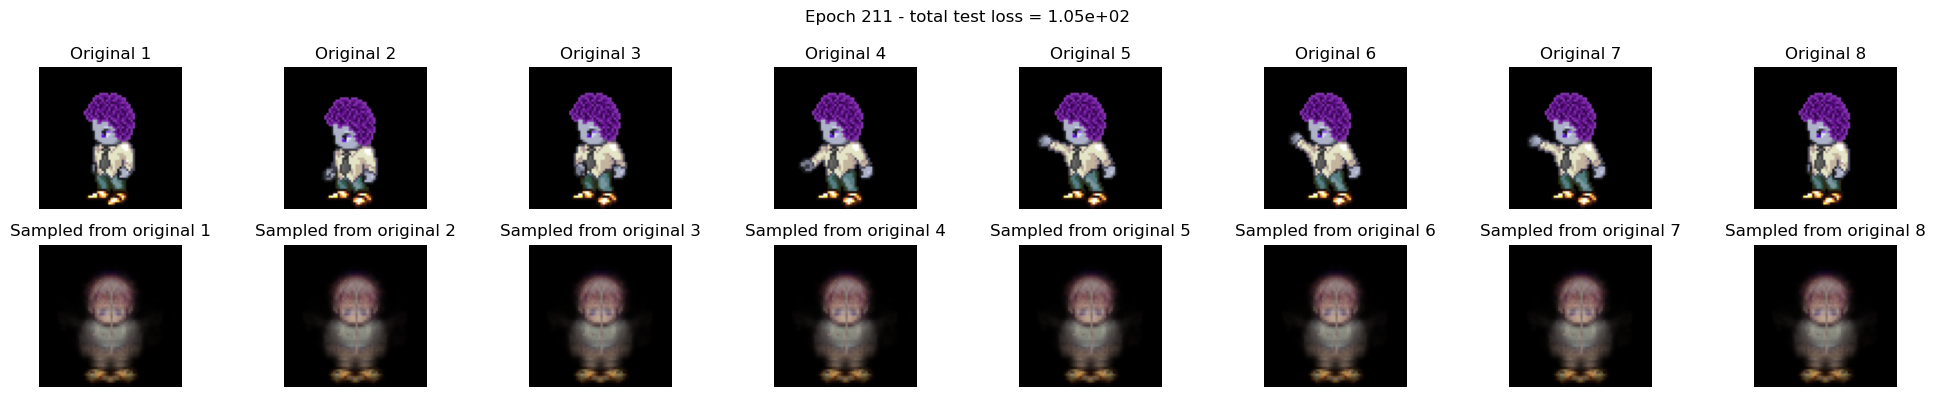

Epoch [212    .../... 300   ] beta = 1.00 -- TRAIN : (Total) 2.7038e+02 (Rec VRNN) -1.4845e+01 (KL) 2.5258e-04 (Rec CNN) 2.8522e+02 -- TEST : (Total) 8.4239e+01 (Rec VRNN) -1.0386e+01 (KL) 2.1135e-05 (Rec CNN) 9.4625e+01 -- Early stopping counter: 2 / 20
Epoch [213    .../... 300   ] beta = 1.00 -- TRAIN : (Total) 2.5303e+02 (Rec VRNN) -3.2153e+01 (KL) 4.0705e-05 (Rec CNN) 2.8518e+02 -- TEST : (Total) 8.3460e+01 (Rec VRNN) -1.1144e+01 (KL) 2.9195e-06 (Rec CNN) 9.4605e+01 -- Early stopping counter: 3 / 20
Epoch [214    .../... 300   ] beta = 1.00 -- TRAIN : (Total) 2.5138e+02 (Rec VRNN) -3.3788e+01 (KL) 5.6559e-06 (Rec CNN) 2.8517e+02 -- TEST : (Total) 8.3274e+01 (Rec VRNN) -1.1342e+01 (KL) 1.7237e-08 (Rec CNN) 9.4616e+01 -- Early stopping counter: 4 / 20
Epoch [215    .../... 300   ] beta = 1.00 -- TRAIN : (Total) 2.5109e+02 (Rec VRNN) -3.4185e+01 (KL) 3.0556e-07 (Rec CNN) 2.8527e+02 -- TEST : (Total) 8.3250e+01 (Rec VRNN) -1.1438e+01 (KL) 4.4715e-09 (Rec CNN) 9.4688e+01 -- Early stopp

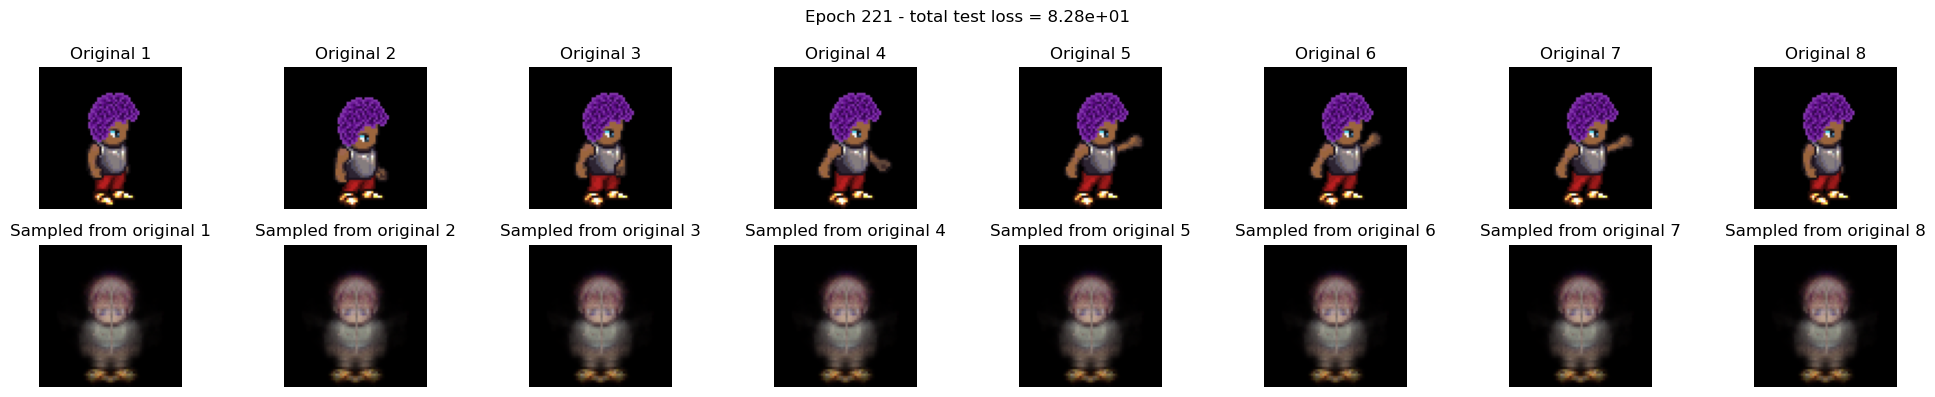

Epoch [222    .../... 300   ] beta = 1.00 -- TRAIN : (Total) 2.4976e+02 (Rec VRNN) -3.5603e+01 (KL) 1.4900e-08 (Rec CNN) 2.8536e+02 -- TEST : (Total) 8.2711e+01 (Rec VRNN) -1.1903e+01 (KL) 5.9959e-09 (Rec CNN) 9.4615e+01 -- Early stopping counter: 12 / 20
Epoch [223    .../... 300   ] beta = 1.00 -- TRAIN : (Total) 2.4932e+02 (Rec VRNN) -3.5807e+01 (KL) 1.9239e-08 (Rec CNN) 2.8513e+02 -- TEST : (Total) 8.2644e+01 (Rec VRNN) -1.1972e+01 (KL) 6.1750e-09 (Rec CNN) 9.4616e+01 -- Early stopping counter: 13 / 20
Epoch [224    .../... 300   ] beta = 1.00 -- TRAIN : (Total) 2.4918e+02 (Rec VRNN) -3.6014e+01 (KL) 1.7317e-08 (Rec CNN) 2.8519e+02 -- TEST : (Total) 8.2570e+01 (Rec VRNN) -1.2041e+01 (KL) 4.8427e-09 (Rec CNN) 9.4611e+01 -- Early stopping counter: 14 / 20
Epoch [225    .../... 300   ] beta = 1.00 -- TRAIN : (Total) 2.4910e+02 (Rec VRNN) -3.6222e+01 (KL) 1.6565e-08 (Rec CNN) 2.8532e+02 -- TEST : (Total) 8.2535e+01 (Rec VRNN) -1.2111e+01 (KL) 3.7213e-09 (Rec CNN) 9.4646e+01 -- Early st

In [21]:
# Training !!
if device.type == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = round(torch.cuda.get_device_properties(0).total_memory/1024**3,1)
    print(f"Using GPU: {gpu_name} with {gpu_memory} GB memory")
    
n_epochs = 300
display_interval = 10  # How often to display images
T = X_train.shape[1]  # Number of time steps in the sequences
stop = False

# record train losses
train_losses = []
train_rec_vrnn_losses = []
train_rec_cnn_losses = []
train_kl_losses = []
# record test losses
test_losses = []
test_rec_vrnn_losses = []
test_rec_cnn_losses = []
test_kl_losses = []
# betas
betas = []

# start the clock
start = timeit.default_timer()

# beta management
beta = 0.0
beta_scheduler = BetaLinearScheduler(
    beta_start=0.0,
    beta_end=1.0,
    epoch_start=100,
    num_epochs=100
)
train_rec_vrnn_loss = 1.0

if beta_scheduler is not None:
    print(f"Beta scheduler: {beta_scheduler}")
else:
    print(f"Beta scheduler: None, beta = {beta:.3e}")

for epoch in range(n_epochs):
    
    # use the beat scheduler if provided
    if beta_scheduler is not None:
        beta = beta_scheduler(epoch, train_rec_vrnn_loss)
    betas.append(beta)
    
    # training and testing steps
    pre_encoder, vrnn, post_decoder, train_rec_vrnn_loss, train_kl_loss, train_rec_cnn_loss, total_train_loss = train_step(
        pre_encoder, vrnn, post_decoder, 
        train_loader, 
        learning_rate, criterion, optimizer, 
        beta=beta
    )
    test_rec_vrnn_loss, test_kl_loss, test_rec_cnn_loss, total_test_loss = test_step(pre_encoder, vrnn, post_decoder, test_loader)
    
    # log train losses
    train_losses.append(total_train_loss)
    train_rec_vrnn_losses.append(train_rec_vrnn_loss)
    train_rec_cnn_losses.append(train_rec_cnn_loss)
    train_kl_losses.append(train_kl_loss)

    # log test losses
    test_losses.append(total_test_loss)
    test_rec_vrnn_losses.append(test_rec_vrnn_loss)
    test_rec_cnn_losses.append(test_rec_cnn_loss)
    test_kl_losses.append(test_kl_loss)
    
    # Early stopping check
    if early_stopper:
        stop, counter = early_stopper.early_stop(total_test_loss)
        if stop:
            msg = f'Early stopping at epoch {epoch+1} with counter {counter}'
            stop = True
        else:
            msg = f'Early stopping counter: {counter} / {early_stopper.patience}'
    
    # reporting        
    print(f'Epoch [{epoch+1:<6} .../... {n_epochs:<6}] beta = {beta:.2f} -- ' + \
        f'TRAIN : (Total) {total_train_loss:.4e} (Rec VRNN) {train_rec_vrnn_loss:.4e} (KL) {train_kl_loss:.4e} (Rec CNN) {train_rec_cnn_loss:.4e} -- ' +\
        f'TEST : (Total) {total_test_loss:.4e} (Rec VRNN) {test_rec_vrnn_loss:.4e} (KL) {test_kl_loss:.4e} (Rec CNN) {test_rec_cnn_loss:.4e} ' +\
        f'-- {msg}'
    )
    
    if stop:
        print("Early stopping triggered. Stopping training.")
        break
    
    # check images every NN epochs
    if (epoch) % display_interval == 0:
        with torch.no_grad():
            # get one sequence of images from the test set
            idx = np.random.choice(X_test.shape[0], 1, replace=False)
            image = torch.tensor(X_test[idx]).to(device)  # (1, T, W, H, C)
            img_encoded = pre_encoder(image.permute(1, 0, 2, 3, 4).to(device)) # (T, B, Dx)
            x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t = vrnn(img_encoded)  # mu_x_t (T,B,Dx), logvar_x_t (T,B,Dx)
            sampled_xs = mu_x_t + torch.randn_like(mu_x_t) * torch.exp(0.5 * logvar_x_t)  # (T, B, Dx)
            x_hat = post_decoder(sampled_xs)  # (T, B, 64, 64, 3)
            x_hat = x_hat.permute(1, 0, 2, 3, 4)  # (B, T, W, H, C)
            # plot 
            fig, ax = plt.subplots(nrows=2, ncols=T, figsize=(20, 2 * 2))
            for j in range(X_test.shape[1]):
                # Original images
                ax[0,j].imshow(image[0, j].cpu().numpy())
                ax[0,j].axis('off')
                ax[0,j].set_title(f'Original {j+1}')
                # Reconstructed images
                ax[1,j].imshow(x_hat[0, j].detach().cpu().numpy())
                ax[1,j].axis('off')
                ax[1,j].set_title(f'Sampled from original {j+1}')
            fig.suptitle(f'Epoch {epoch+1} - total test loss = {total_test_loss:.2e}', fontsize=12)
            plt.tight_layout()
            plt.show()
    
end = timeit.default_timer()

print(f"Trained {n_epochs} epochs in {end - start:.2f} seconds on {gpu_name} with {gpu_memory} GB memory")

# Plot losses

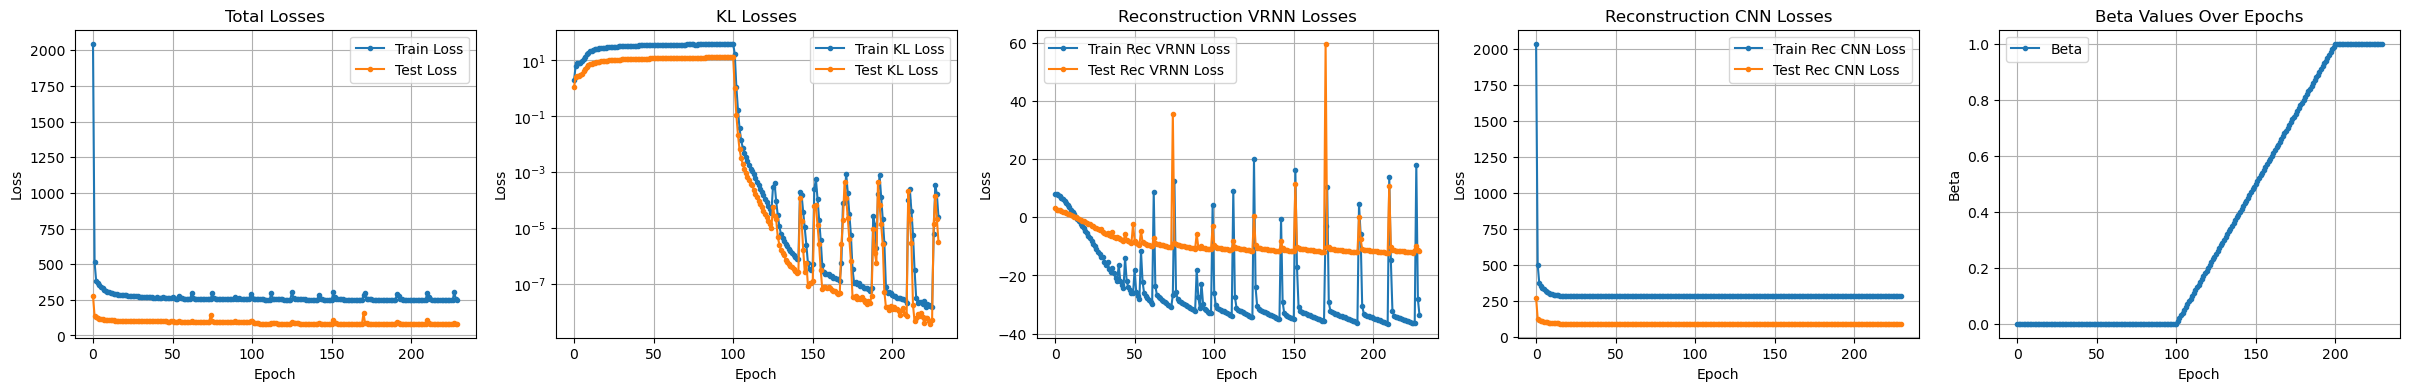

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(30, 4))

# plot total losses
ax[0].plot(train_losses, label='Train Loss', marker='.')
ax[0].plot(test_losses, label='Test Loss', marker='.')
ax[0].set_title('Total Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

# plot kl losses
ax[1].plot(train_kl_losses, label='Train KL Loss', marker='.')
ax[1].plot(test_kl_losses, label='Test KL Loss', marker='.')
ax[1].set_title('KL Losses')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')   
ax[1].set_yscale('log')  # Log scale for better visibility 
ax[1].legend()
ax[1].grid(True)

# plot reconstruction losses VRNN
ax[2].plot(train_rec_vrnn_losses, label='Train Rec VRNN Loss', marker='.')
ax[2].plot(test_rec_vrnn_losses, label='Test Rec VRNN Loss', marker='.')
ax[2].set_title('Reconstruction VRNN Losses')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
ax[2].grid(True)

# plot reconstrcution losses CNN
ax[3].plot(train_rec_cnn_losses, label='Train Rec CNN Loss', marker='.')
ax[3].plot(test_rec_cnn_losses, label='Test Rec CNN Loss', marker='.')
ax[3].set_title('Reconstruction CNN Losses')
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].legend()
ax[3].grid(True)

# plot betas
ax[4].plot(betas, label='Beta', marker='.')
ax[4].set_title('Beta Values Over Epochs')
ax[4].set_xlabel('Epoch')
ax[4].set_ylabel('Beta')
ax[4].legend()
ax[4].grid(True)   

# Some visualisation - reconstruction

In [23]:
N_SAMPLES = 5

idx = np.random.choice(X_test.shape[0], N_SAMPLES, replace=False)

images = torch.tensor(X_test[idx]).to(device)

x_encoded = pre_encoder(images.permute(1, 0, 2, 3, 4).to(device))  # (T, B, Dx)
x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t = vrnn(x_encoded)  # mu_x_t (T,B,Dx), logvar_x_t (T,B,Dx)
sampled_xs = mu_x_t + torch.randn_like(mu_x_t) * torch.exp(0.5 * logvar_x_t)  # (T, B, Dx)
x_hat = post_decoder(sampled_xs)  # (T, B, 64, 64, 3)
# x_hat = post_decoder(x_encoded)  # (T, B, 64, 64, 3)  ND - AE SEULEMENT !!
x_hat = x_hat.permute(1, 0, 2, 3, 4)  # (B, T, W, H, C)

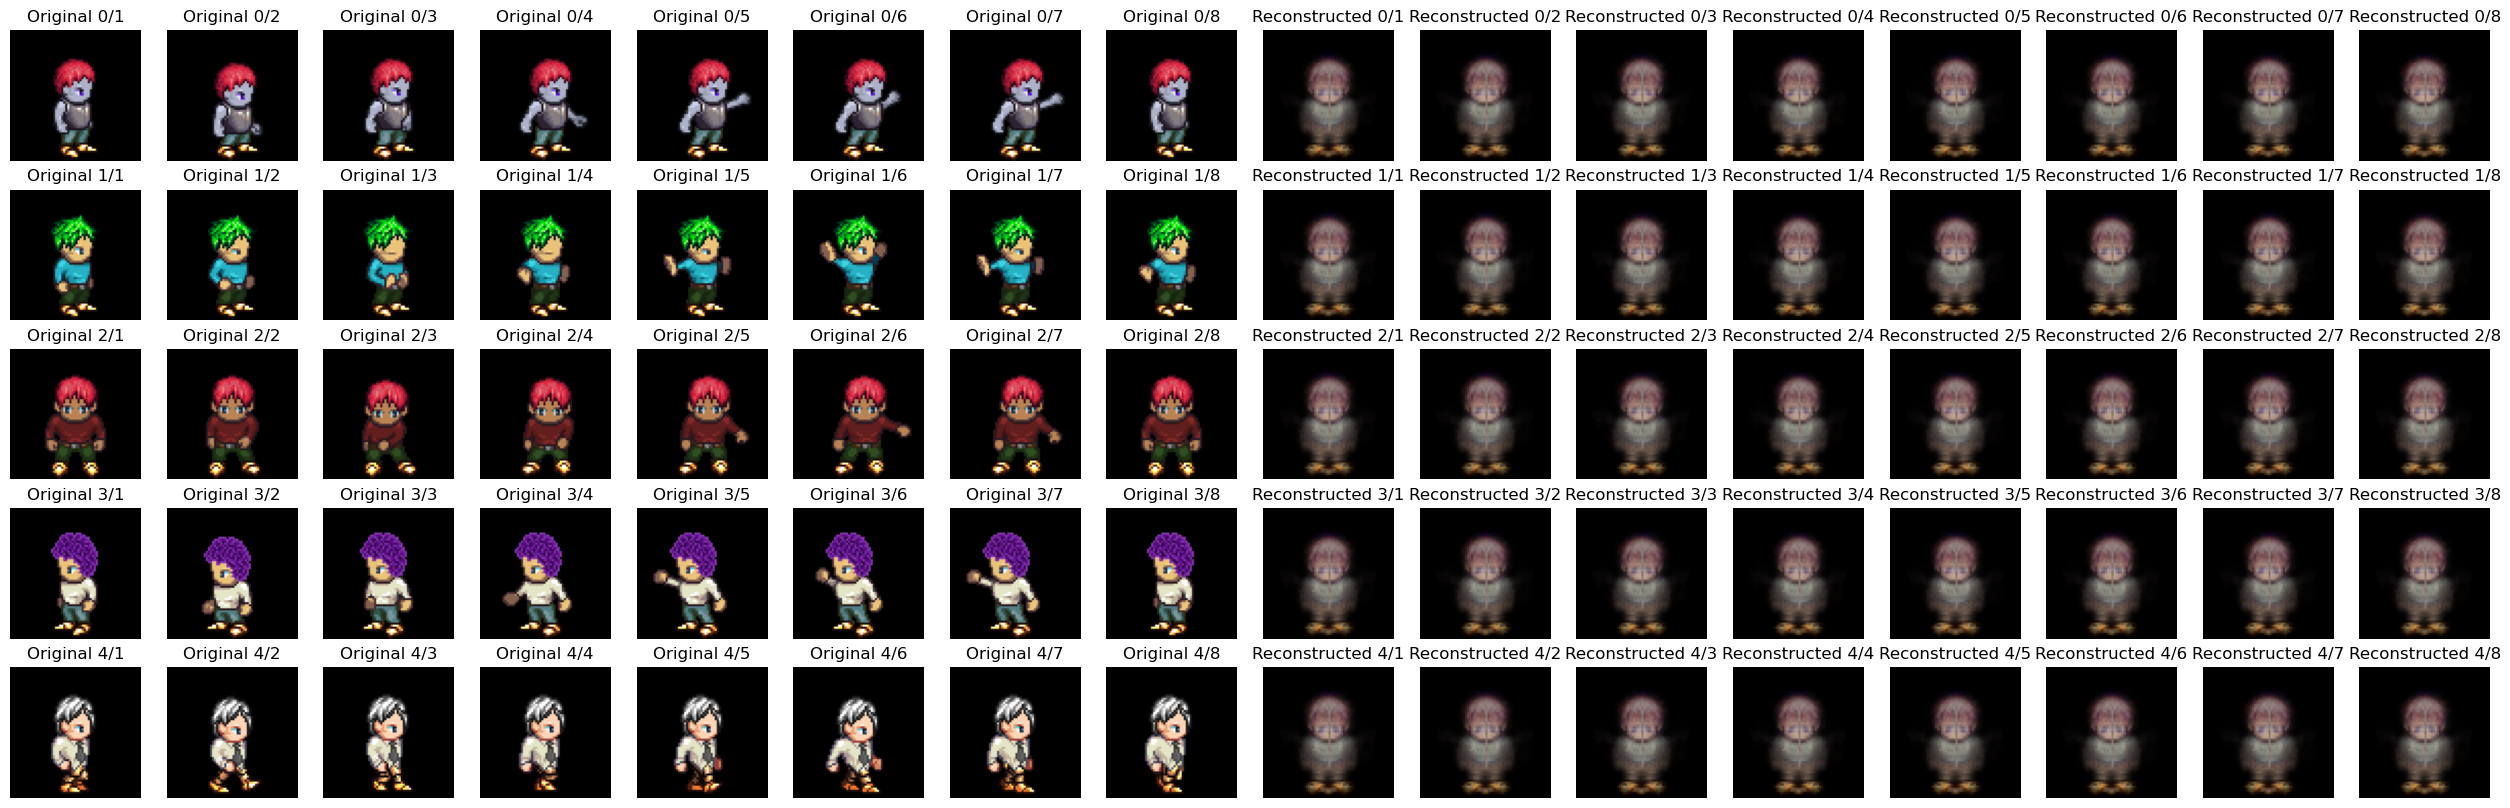

In [24]:
T = x_hat.shape[1]  # Number of time steps
fig, ax = plt.subplots(nrows=N_SAMPLES, ncols=2*T, figsize=(32, 2 * N_SAMPLES))
for i, id_seq in enumerate(idx):

    for j in range(X_test.shape[1]):
        # Original images
        ax[i, j].imshow(images[i, j].cpu().numpy())
        ax[i, j].axis('off')
        ax[i, j].set_title(f'Original {i}/{j+1}')
        
        # Reconstructed images
        ax[i, T+j].imshow(x_hat[i, j].detach().cpu().numpy())
        ax[i, T+j].axis('off')
        ax[i, T+j].set_title(f'Reconstructed {i}/{j+1}')